# Sample Selection

In [ ]:
!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Path to the main folder containing the subfolders
main_folder_path = '/content/drive/MyDrive/Highlights Project/frames'

# Get the list of folders
folders = [os.path.join(main_folder_path, f) for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]

for folder in folders:
    # List to hold image file paths
    image_files = []

    # Get all the image file paths in the folder
    for img in os.listdir(folder):
        if img.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(folder, img))

    # Create a dataframe with all these images
    df_name = 'df_' + os.path.basename(folder).replace(' ', '_')
    image_df = pd.DataFrame(image_files, columns=['image_path'])


    sample_size = 150 if len(image_df) > 150 else len(image_df)
    sampled_df = image_df.sample(n=sample_size, random_state=42)

    # Assign the DataFrame to a variable in the global namespace
    globals()[df_name] = sampled_df

    # Optionally, you can print or save the DataFrame to verify the content
    print(f"Created DataFrame: {df_name} with {len(sampled_df)} images.")

    # Display the progress for sampling
    for _ in tqdm(range(sample_size), desc=f"Sampling {os.path.basename(folder)}", leave=False):
        pass

Created DataFrame: df_arsenal with 150 images.


Created DataFrame: df_.ipynb_checkpoints with 0 images.


Created DataFrame: df_chelsea with 150 images.


Created DataFrame: df_Man_City with 150 images.


Created DataFrame: df_Man_United with 150 images.


Created DataFrame: df_Spurs with 150 images.


# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [ ]:
%%capture
!pip install facenet-pytorch

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/drive/MyDrive/Highlights Project/players')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Face detected with probability: 0.999999
Face detected with probability: 0.999925
Face detected with probability: 0.999935
Face detected with probability: 0.999905
Face detected with probability: 0.999752
Face detected with probability: 0.999994
Face detected with probability: 0.999790
Face detected with probability: 0.998826
Face detected with probability: 0.999925
Face detected with probability: 0.999861
Face detected with probability: 0.999999
Face detected with probability: 0.972276
Face detected with probability: 0.999858
Face detected with probability: 0.999991
Face detected with probability: 0.999993
Face detected with probability: 0.999949
Face detected with probability: 0.999998
Face detected with probability: 0.999817
Face detected with probability: 1.000000
Face detected with probability: 0.999928
Face detected with probability: 0.998893
Face detected with probability: 0.998893
Face detected with probability: 0.999935
Face detected with probability: 0.998325
Face detected wi

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

          Allison   Allison   Allison   Allison   Allison   Allison   Allison  \
Allison  0.000000  0.681722  0.722625  0.980780  0.702386  0.775420  0.779453   
Allison  0.681722  0.000000  0.744969  0.853368  0.666061  0.787382  0.715985   
Allison  0.722625  0.744969  0.000000  0.847611  0.803740  0.772045  0.722318   
Allison  0.980780  0.853368  0.847611  0.000000  0.892409  0.973563  0.841779   
Allison  0.702386  0.666061  0.803740  0.892409  0.000000  0.699962  0.799298   
...           ...       ...       ...       ...       ...       ...       ...   
salah    1.124527  1.010216  1.126773  1.220679  1.076701  1.079687  1.157010   
salah    1.158345  1.124393  1.180622  1.255121  1.117477  1.124086  1.213308   
salah    0.932941  1.033612  1.165578  1.218297  0.992595  1.090612  1.108330   
salah    1.150661  1.038031  1.138822  1.245717  1.014468  1.047604  1.162140   
salah    1.114163  1.080445  1.176958  1.128132  1.038452  1.171556  1.147928   

          Allison   Allison

### Get Counts

In [ ]:
import csv
import numpy as np
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
from tqdm import tqdm
from collections import defaultdict
from scipy.spatial.distance import cosine


# Dictionary of DataFrames
dataframes = {
    'df_Arsenal': df_arsenal,
    'df_Chelsea': df_chelsea,
    'df_Man_City': df_Man_City,
    'df_Man_United': df_Man_United,
    'df_Spurs': df_Spurs
}

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device:', device)

# Initialize models
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20,
              thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
              device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load dataset for class embeddings
dataset = datasets.ImageFolder('/content/drive/MyDrive/Highlights Project/players')
classes = dataset.classes
class_embeddings = {class_name: [] for class_name in classes}

# Pre-compute embeddings for all classes
for class_name in classes:
    class_idx = dataset.class_to_idx[class_name]
    for img, idx in dataset:
        if idx == class_idx:
            img_aligned, _ = mtcnn(img, return_prob=True)
            if img_aligned is not None:
                img_aligned = torch.unsqueeze(torch.FloatTensor(img_aligned), 0).to(device)
                class_embeddings[class_name].append(resnet(img_aligned).detach().cpu().numpy().flatten())
    class_embeddings[class_name] = np.stack(class_embeddings[class_name]) if class_embeddings[class_name] else np.array([])

# Function to process images from a DataFrame
def process_images(df, df_name):
    class_count = defaultdict(int)

    for image_file in tqdm(df['image_path'], desc=f"Processing {df_name}"):
        try:
            image = Image.open(image_file)
            image_np = np.array(image)
            aligned_face, prob = mtcnn(image_np, return_prob=True)
            if aligned_face is not None:
                aligned_face_tensor = torch.unsqueeze(torch.FloatTensor(aligned_face), 0).to(device)
                image_embedding = resnet(aligned_face_tensor).detach().cpu().numpy().flatten()
                class_distances = {cname: min(cosine(image_embedding, e) for e in embeddings) for cname, embeddings in class_embeddings.items() if embeddings.size > 0}
                total_distance = sum(class_distances.values())
                class_confidence = {cname: np.exp(-dist) / total_distance for cname, dist in class_distances.items()}

                predicted_class = max(class_confidence, key=class_confidence.get)
                predicted_confidence = class_confidence[predicted_class]
                class_count[predicted_class] += 1

                print("\nPredicted class:", predicted_class)
                print("Confidence score:", predicted_confidence)
        except Exception as e:
            print("Error processing file:", image_file, "; Error:", e)

    # Save class counts to CSV
    csv_file_path = f"/content/drive/MyDrive/Highlights Project/frames/frames_smaller/{df_name}_counts.csv"
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Class', 'Count'])
        for class_name, count in class_count.items():
            writer.writerow([class_name, count])

    print(f"Class counts saved to: {csv_file_path}")

# Process each DataFrame
for df_name, df in dataframes.items():
    process_images(df, df_name)

Running on device: cuda:0


Processing df_Arsenal:   1%|          | 1/150 [00:01<02:39,  1.07s/it]


Predicted class: Gakpo
Confidence score: 0.04774661185378978


Processing df_Arsenal:   1%|▏         | 2/150 [00:01<02:24,  1.03it/s]


Predicted class: Boby Clark
Confidence score: 0.04598388241984961


Processing df_Arsenal:   2%|▏         | 3/150 [00:02<02:12,  1.11it/s]


Predicted class: gomez
Confidence score: 0.047790420586179536


Processing df_Arsenal:   3%|▎         | 4/150 [00:03<02:06,  1.16it/s]


Predicted class: salah
Confidence score: 0.042623786771736644


Processing df_Arsenal:   3%|▎         | 5/150 [00:04<02:11,  1.10it/s]


Predicted class: Boby Clark
Confidence score: 0.033570818467017524


Processing df_Arsenal:   4%|▍         | 6/150 [00:05<02:05,  1.15it/s]


Predicted class: KOnate
Confidence score: 0.04431256066792964


Processing df_Arsenal:   5%|▍         | 7/150 [00:06<02:07,  1.12it/s]


Predicted class: quansah
Confidence score: 0.028070580576048318


Processing df_Arsenal:   5%|▌         | 8/150 [00:07<02:04,  1.15it/s]


Predicted class: Gravenbergh
Confidence score: 0.04110743415379272


Processing df_Arsenal:   6%|▌         | 9/150 [00:08<02:10,  1.08it/s]


Predicted class: KOnate
Confidence score: 0.024878849957256297


Processing df_Arsenal:   7%|▋         | 10/150 [00:08<02:03,  1.13it/s]


Predicted class: gomez
Confidence score: 0.04809173275293222


Processing df_Arsenal:   7%|▋         | 11/150 [00:09<02:00,  1.16it/s]


Predicted class: arnold
Confidence score: 0.03571671634809245


Processing df_Arsenal:   8%|▊         | 12/150 [00:10<01:59,  1.16it/s]


Predicted class: Nunez
Confidence score: 0.05808315387525798


Processing df_Arsenal:   9%|▉         | 14/150 [00:12<02:21,  1.04s/it]


Predicted class: Mac Allister
Confidence score: 0.03270565435124881


Processing df_Arsenal:  10%|█         | 15/150 [00:13<02:12,  1.02it/s]


Predicted class: arnold
Confidence score: 0.051058157527711825


Processing df_Arsenal:  11%|█         | 16/150 [00:15<02:23,  1.07s/it]


Predicted class: Endo
Confidence score: 0.03837842342174853


Processing df_Arsenal:  11%|█▏        | 17/150 [00:15<02:14,  1.02s/it]


Predicted class: Endo
Confidence score: 0.05711078690871508


Processing df_Arsenal:  12%|█▏        | 18/150 [00:16<02:11,  1.01it/s]


Predicted class: salah
Confidence score: 0.04673215913619849


Processing df_Arsenal:  13%|█▎        | 19/150 [00:17<02:03,  1.07it/s]


Predicted class: KOnate
Confidence score: 0.04146789159482101


Processing df_Arsenal:  13%|█▎        | 20/150 [00:18<02:11,  1.01s/it]


Predicted class: Jota
Confidence score: 0.05194860954423423


Processing df_Arsenal:  14%|█▍        | 21/150 [00:19<02:03,  1.04it/s]


Predicted class: Gakpo
Confidence score: 0.042909084473023856


Processing df_Arsenal:  15%|█▍        | 22/150 [00:20<02:03,  1.04it/s]


Predicted class: Kelleher
Confidence score: 0.03302746137090261


Processing df_Arsenal:  15%|█▌        | 23/150 [00:21<02:06,  1.01it/s]


Predicted class: salah
Confidence score: 0.04594225235132035


Processing df_Arsenal:  16%|█▌        | 24/150 [00:22<02:09,  1.03s/it]


Predicted class: KOnate
Confidence score: 0.045308098592687834


Processing df_Arsenal:  17%|█▋        | 25/150 [00:23<02:02,  1.02it/s]


Predicted class: KOnate
Confidence score: 0.04236579101306442


Processing df_Arsenal:  18%|█▊        | 27/150 [00:25<01:53,  1.08it/s]


Predicted class: Nunez
Confidence score: 0.038371136832029466


Processing df_Arsenal:  19%|█▊        | 28/150 [00:26<01:50,  1.10it/s]


Predicted class: Allison
Confidence score: 0.03350192827208378


Processing df_Arsenal:  19%|█▉        | 29/150 [00:27<01:51,  1.09it/s]


Predicted class: quansah
Confidence score: 0.04756705269047295


Processing df_Arsenal:  20%|██        | 30/150 [00:28<01:50,  1.09it/s]


Predicted class: Endo
Confidence score: 0.04337365803147282


Processing df_Arsenal:  21%|██        | 31/150 [00:29<01:48,  1.10it/s]


Predicted class: salah
Confidence score: 0.04464889235023015


Processing df_Arsenal:  21%|██▏       | 32/150 [00:29<01:43,  1.14it/s]


Predicted class: Jones
Confidence score: 0.051327044747948115


Processing df_Arsenal:  22%|██▏       | 33/150 [00:30<01:41,  1.15it/s]


Predicted class: Elliot
Confidence score: 0.05614831461722617


Processing df_Arsenal:  23%|██▎       | 34/150 [00:31<01:40,  1.16it/s]


Predicted class: Allison
Confidence score: 0.04610498776398


Processing df_Arsenal:  23%|██▎       | 35/150 [00:32<01:40,  1.14it/s]


Predicted class: Nunez
Confidence score: 0.05142189319430035


Processing df_Arsenal:  25%|██▍       | 37/150 [00:34<01:33,  1.20it/s]


Predicted class: arnold
Confidence score: 0.05582739296900051


Processing df_Arsenal:  25%|██▌       | 38/150 [00:34<01:32,  1.21it/s]


Predicted class: gomez
Confidence score: 0.047528593356295945


Processing df_Arsenal:  26%|██▌       | 39/150 [00:35<01:32,  1.19it/s]


Predicted class: salah
Confidence score: 0.07038531451321597


Processing df_Arsenal:  27%|██▋       | 40/150 [00:36<01:33,  1.18it/s]


Predicted class: arnold
Confidence score: 0.05996825022166709


Processing df_Arsenal:  27%|██▋       | 41/150 [00:37<01:31,  1.19it/s]


Predicted class: salah
Confidence score: 0.04506080734998655


Processing df_Arsenal:  28%|██▊       | 42/150 [00:38<01:30,  1.19it/s]


Predicted class: Kelleher
Confidence score: 0.027646686126623927


Processing df_Arsenal:  29%|██▊       | 43/150 [00:39<01:32,  1.15it/s]


Predicted class: Mac Allister
Confidence score: 0.05784707876871603


Processing df_Arsenal:  29%|██▉       | 44/150 [00:40<01:34,  1.12it/s]


Predicted class: Boby Clark
Confidence score: 0.02985426023302356


Processing df_Arsenal:  31%|███▏      | 47/150 [00:42<01:32,  1.12it/s]


Predicted class: Jota
Confidence score: 0.05724505396303935


Processing df_Arsenal:  32%|███▏      | 48/150 [00:43<01:31,  1.12it/s]


Predicted class: Robertson
Confidence score: 0.03552860436902171


Processing df_Arsenal:  33%|███▎      | 50/150 [00:45<01:28,  1.13it/s]


Predicted class: salah
Confidence score: 0.040489463321194026


Processing df_Arsenal:  34%|███▍      | 51/150 [00:46<01:28,  1.12it/s]


Predicted class: Elliot
Confidence score: 0.045201053596984744


Processing df_Arsenal:  35%|███▍      | 52/150 [00:47<01:34,  1.04it/s]


Predicted class: salah
Confidence score: 0.03515572169088085


Processing df_Arsenal:  35%|███▌      | 53/150 [00:48<01:29,  1.08it/s]


Predicted class: salah
Confidence score: 0.04085242314550123


Processing df_Arsenal:  37%|███▋      | 55/150 [00:49<01:21,  1.16it/s]


Predicted class: Robertson
Confidence score: 0.048794126983635694


Processing df_Arsenal:  37%|███▋      | 56/150 [00:51<01:32,  1.01it/s]


Predicted class: KOnate
Confidence score: 0.043767272245300304


Processing df_Arsenal:  38%|███▊      | 57/150 [00:52<01:31,  1.02it/s]


Predicted class: Vandijk
Confidence score: 0.04297658495242716


Processing df_Arsenal:  39%|███▉      | 59/150 [00:53<01:26,  1.05it/s]


Predicted class: Diaz
Confidence score: 0.036121669174237626


Processing df_Arsenal:  40%|████      | 60/150 [00:54<01:23,  1.08it/s]


Predicted class: Endo
Confidence score: 0.04318787673471479


Processing df_Arsenal:  41%|████      | 61/150 [00:55<01:30,  1.02s/it]


Predicted class: Elliot
Confidence score: 0.055845048017520715


Processing df_Arsenal:  41%|████▏     | 62/150 [00:56<01:29,  1.02s/it]


Predicted class: Jones
Confidence score: 0.06637347027503236


Processing df_Arsenal:  42%|████▏     | 63/150 [00:58<01:32,  1.07s/it]


Predicted class: Mac Allister
Confidence score: 0.04304916737834703


Processing df_Arsenal:  43%|████▎     | 64/150 [00:59<01:27,  1.01s/it]


Predicted class: salah
Confidence score: 0.07315192335866678


Processing df_Arsenal:  43%|████▎     | 65/150 [00:59<01:21,  1.04it/s]


Predicted class: Mac Allister
Confidence score: 0.04396392741270692


Processing df_Arsenal:  45%|████▍     | 67/150 [01:01<01:19,  1.04it/s]


Predicted class: salah
Confidence score: 0.04127547526330131


Processing df_Arsenal:  45%|████▌     | 68/150 [01:02<01:15,  1.08it/s]


Predicted class: Elliot
Confidence score: 0.053628580449147804


Processing df_Arsenal:  47%|████▋     | 70/150 [01:04<01:13,  1.09it/s]


Predicted class: salah
Confidence score: 0.04855501820073251


Processing df_Arsenal:  47%|████▋     | 71/150 [01:05<01:13,  1.08it/s]


Predicted class: quansah
Confidence score: 0.04632959235839298


Processing df_Arsenal:  49%|████▊     | 73/150 [01:06<01:08,  1.13it/s]


Predicted class: Mac Allister
Confidence score: 0.055215083648869456


Processing df_Arsenal:  49%|████▉     | 74/150 [01:07<01:07,  1.12it/s]


Predicted class: Gakpo
Confidence score: 0.038611160068512916


Processing df_Arsenal:  50%|█████     | 75/150 [01:08<01:05,  1.15it/s]


Predicted class: Elliot
Confidence score: 0.05386749352222386


Processing df_Arsenal:  51%|█████     | 76/150 [01:09<01:04,  1.15it/s]


Predicted class: Bradley
Confidence score: 0.04090887184896555


Processing df_Arsenal:  53%|█████▎    | 79/150 [01:11<00:58,  1.21it/s]


Predicted class: Robertson
Confidence score: 0.03722544460379688


Processing df_Arsenal:  53%|█████▎    | 80/150 [01:12<01:00,  1.15it/s]


Predicted class: Endo
Confidence score: 0.04225079740024225


Processing df_Arsenal:  54%|█████▍    | 81/150 [01:14<01:05,  1.06it/s]


Predicted class: Jota
Confidence score: 0.04362938067257827


Processing df_Arsenal:  55%|█████▍    | 82/150 [01:14<01:03,  1.07it/s]


Predicted class: Allison
Confidence score: 0.03164524481779852


Processing df_Arsenal:  55%|█████▌    | 83/150 [01:15<01:00,  1.11it/s]


Predicted class: salah
Confidence score: 0.03952236906667359


Processing df_Arsenal:  56%|█████▌    | 84/150 [01:16<00:57,  1.14it/s]


Predicted class: Kelleher
Confidence score: 0.03371853160657885


Processing df_Arsenal:  57%|█████▋    | 85/150 [01:17<00:54,  1.19it/s]


Predicted class: Jones
Confidence score: 0.04668734610267026


Processing df_Arsenal:  57%|█████▋    | 86/150 [01:18<00:54,  1.18it/s]


Predicted class: Allison
Confidence score: 0.045679584183093466


Processing df_Arsenal:  58%|█████▊    | 87/150 [01:19<00:53,  1.17it/s]


Predicted class: Gakpo
Confidence score: 0.04645984531842042


Processing df_Arsenal:  59%|█████▊    | 88/150 [01:19<00:53,  1.17it/s]


Predicted class: gomez
Confidence score: 0.05299950243810786


Processing df_Arsenal:  59%|█████▉    | 89/150 [01:20<00:53,  1.14it/s]


Predicted class: quansah
Confidence score: 0.04406701807038477


Processing df_Arsenal:  60%|██████    | 90/150 [01:21<00:54,  1.11it/s]


Predicted class: Diaz
Confidence score: 0.04967547324936236


Processing df_Arsenal:  61%|██████    | 91/150 [01:22<00:52,  1.12it/s]


Predicted class: Gravenbergh
Confidence score: 0.0459447107818155


Processing df_Arsenal:  62%|██████▏   | 93/150 [01:24<00:50,  1.13it/s]


Predicted class: salah
Confidence score: 0.06199050716388602


Processing df_Arsenal:  63%|██████▎   | 94/150 [01:25<00:49,  1.13it/s]


Predicted class: Robertson
Confidence score: 0.03697284548398892


Processing df_Arsenal:  63%|██████▎   | 95/150 [01:26<00:49,  1.12it/s]


Predicted class: salah
Confidence score: 0.05751842960686699


Processing df_Arsenal:  64%|██████▍   | 96/150 [01:27<00:50,  1.07it/s]


Predicted class: Gravenbergh
Confidence score: 0.04498536795734839


Processing df_Arsenal:  65%|██████▍   | 97/150 [01:28<00:48,  1.10it/s]


Predicted class: Elliot
Confidence score: 0.054155350362924626


Processing df_Arsenal:  65%|██████▌   | 98/150 [01:28<00:45,  1.14it/s]


Predicted class: Boby Clark
Confidence score: 0.03816503815490159


Processing df_Arsenal:  66%|██████▌   | 99/150 [01:29<00:44,  1.14it/s]


Predicted class: Mac Allister
Confidence score: 0.04940966946801897


Processing df_Arsenal:  67%|██████▋   | 100/150 [01:30<00:42,  1.17it/s]


Predicted class: gomez
Confidence score: 0.04851840489867893


Processing df_Arsenal:  67%|██████▋   | 101/150 [01:31<00:40,  1.20it/s]


Predicted class: salah
Confidence score: 0.06839324492866206


Processing df_Arsenal:  68%|██████▊   | 102/150 [01:32<00:42,  1.13it/s]


Predicted class: salah
Confidence score: 0.056180028157061065


Processing df_Arsenal:  69%|██████▊   | 103/150 [01:33<00:41,  1.12it/s]


Predicted class: Vandijk
Confidence score: 0.030165491475593515


Processing df_Arsenal:  69%|██████▉   | 104/150 [01:34<00:39,  1.16it/s]


Predicted class: salah
Confidence score: 0.04343214079539045


Processing df_Arsenal:  70%|███████   | 105/150 [01:34<00:38,  1.18it/s]


Predicted class: Nunez
Confidence score: 0.02892136997845202


Processing df_Arsenal:  71%|███████▏  | 107/150 [01:36<00:37,  1.14it/s]


Predicted class: gomez
Confidence score: 0.05325387509607819


Processing df_Arsenal:  72%|███████▏  | 108/150 [01:37<00:38,  1.09it/s]


Predicted class: salah
Confidence score: 0.05769364335567597


Processing df_Arsenal:  73%|███████▎  | 110/150 [01:39<00:34,  1.15it/s]


Predicted class: Allison
Confidence score: 0.047213312511108455


Processing df_Arsenal:  74%|███████▍  | 111/150 [01:40<00:37,  1.04it/s]


Predicted class: Endo
Confidence score: 0.03774645658375336


Processing df_Arsenal:  75%|███████▍  | 112/150 [01:41<00:39,  1.05s/it]


Predicted class: KOnate
Confidence score: 0.02857669768957907


Processing df_Arsenal:  75%|███████▌  | 113/150 [01:42<00:37,  1.01s/it]


Predicted class: salah
Confidence score: 0.0517128414663698


Processing df_Arsenal:  77%|███████▋  | 115/150 [01:44<00:31,  1.12it/s]


Predicted class: arnold
Confidence score: 0.05381792253742035


Processing df_Arsenal:  78%|███████▊  | 117/150 [01:52<01:38,  2.98s/it]


Predicted class: KOnate
Confidence score: 0.04628605081471095


Processing df_Arsenal:  79%|███████▊  | 118/150 [01:53<01:14,  2.32s/it]


Predicted class: Elliot
Confidence score: 0.041500985856306565


Processing df_Arsenal:  79%|███████▉  | 119/150 [01:54<01:01,  1.98s/it]


Predicted class: salah
Confidence score: 0.04185375411383589


Processing df_Arsenal:  80%|████████  | 120/150 [01:55<00:49,  1.66s/it]


Predicted class: quansah
Confidence score: 0.04097282622736372


Processing df_Arsenal:  81%|████████  | 121/150 [01:56<00:42,  1.47s/it]


Predicted class: Vandijk
Confidence score: 0.036810373043450834


Processing df_Arsenal:  82%|████████▏ | 123/150 [01:58<00:32,  1.19s/it]


Predicted class: Jota
Confidence score: 0.04201761509866139


Processing df_Arsenal:  83%|████████▎ | 125/150 [02:00<00:26,  1.06s/it]


Predicted class: Elliot
Confidence score: 0.04245395629558307


Processing df_Arsenal:  84%|████████▍ | 126/150 [02:01<00:24,  1.04s/it]


Predicted class: Endo
Confidence score: 0.046417367045605354


Processing df_Arsenal:  85%|████████▍ | 127/150 [02:02<00:22,  1.01it/s]


Predicted class: gomez
Confidence score: 0.053790762866117885


Processing df_Arsenal:  85%|████████▌ | 128/150 [02:03<00:20,  1.05it/s]


Predicted class: Kelleher
Confidence score: 0.044023387719865414


Processing df_Arsenal:  86%|████████▌ | 129/150 [02:04<00:19,  1.07it/s]


Predicted class: Vandijk
Confidence score: 0.03401584441112655


Processing df_Arsenal:  87%|████████▋ | 130/150 [02:05<00:18,  1.08it/s]


Predicted class: Jota
Confidence score: 0.04025909662530094


Processing df_Arsenal:  88%|████████▊ | 132/150 [02:06<00:15,  1.18it/s]


Predicted class: arnold
Confidence score: 0.05402172026008646


Processing df_Arsenal:  89%|████████▊ | 133/150 [02:07<00:15,  1.08it/s]


Predicted class: Diaz
Confidence score: 0.05658120919428433


Processing df_Arsenal:  90%|█████████ | 135/150 [02:09<00:13,  1.08it/s]


Predicted class: Gakpo
Confidence score: 0.04584032646280403


Processing df_Arsenal:  91%|█████████ | 136/150 [02:10<00:13,  1.07it/s]


Predicted class: Robertson
Confidence score: 0.04609373420202158


Processing df_Arsenal:  91%|█████████▏| 137/150 [02:11<00:13,  1.04s/it]


Predicted class: arnold
Confidence score: 0.044283368234347684


Processing df_Arsenal:  93%|█████████▎| 139/150 [02:13<00:10,  1.06it/s]


Predicted class: KOnate
Confidence score: 0.04074535067964612


Processing df_Arsenal:  93%|█████████▎| 140/150 [02:14<00:09,  1.06it/s]


Predicted class: Vandijk
Confidence score: 0.030064104049204548


Processing df_Arsenal:  95%|█████████▍| 142/150 [02:16<00:06,  1.14it/s]


Predicted class: gomez
Confidence score: 0.048311633184717505


Processing df_Arsenal:  95%|█████████▌| 143/150 [02:16<00:06,  1.16it/s]


Predicted class: Elliot
Confidence score: 0.049914974011514436


Processing df_Arsenal:  96%|█████████▌| 144/150 [02:17<00:05,  1.19it/s]


Predicted class: arnold
Confidence score: 0.057445828774141845


Processing df_Arsenal:  97%|█████████▋| 145/150 [02:18<00:04,  1.13it/s]


Predicted class: salah
Confidence score: 0.04504429210547258


Processing df_Arsenal:  97%|█████████▋| 146/150 [02:19<00:03,  1.15it/s]


Predicted class: Jones
Confidence score: 0.05070608268000008


Processing df_Arsenal:  98%|█████████▊| 147/150 [02:20<00:02,  1.12it/s]


Predicted class: Kelleher
Confidence score: 0.03181731980774445


Processing df_Arsenal:  99%|█████████▊| 148/150 [02:21<00:01,  1.12it/s]


Predicted class: Endo
Confidence score: 0.05174806636826629


Processing df_Arsenal:  99%|█████████▉| 149/150 [02:22<00:00,  1.16it/s]


Predicted class: KOnate
Confidence score: 0.041850984693640014


Processing df_Arsenal: 100%|██████████| 150/150 [02:23<00:00,  1.05it/s]



Predicted class: salah
Confidence score: 0.044018466307553065
Class counts saved to: /content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Arsenal_counts.csv


Processing df_Chelsea:   1%|          | 1/150 [00:00<02:23,  1.04it/s]


Predicted class: Kelleher
Confidence score: 0.035882380687599025


Processing df_Chelsea:   1%|▏         | 2/150 [00:01<02:24,  1.03it/s]


Predicted class: Vandijk
Confidence score: 0.03745392940497973


Processing df_Chelsea:   2%|▏         | 3/150 [00:02<02:26,  1.00it/s]


Predicted class: Jones
Confidence score: 0.0430846227078802


Processing df_Chelsea:   3%|▎         | 4/150 [00:03<02:17,  1.06it/s]


Predicted class: Mac Allister
Confidence score: 0.047523032512049826


Processing df_Chelsea:   3%|▎         | 5/150 [00:05<02:29,  1.03s/it]


Predicted class: Kelleher
Confidence score: 0.04281765597062935


Processing df_Chelsea:   4%|▍         | 6/150 [00:06<02:34,  1.07s/it]


Predicted class: Zsoboslai
Confidence score: 0.04212568933617904


Processing df_Chelsea:   5%|▍         | 7/150 [00:06<02:20,  1.02it/s]


Predicted class: Nunez
Confidence score: 0.050511516162968735


Processing df_Chelsea:   5%|▌         | 8/150 [00:08<02:24,  1.02s/it]


Predicted class: Gakpo
Confidence score: 0.029227093928531934


Processing df_Chelsea:   6%|▌         | 9/150 [00:08<02:18,  1.02it/s]


Predicted class: Boby Clark
Confidence score: 0.03777242620107642


Processing df_Chelsea:   7%|▋         | 10/150 [00:10<02:27,  1.05s/it]


Predicted class: Diaz
Confidence score: 0.036864995815809556


Processing df_Chelsea:   7%|▋         | 11/150 [00:11<02:38,  1.14s/it]


Predicted class: KOnate
Confidence score: 0.03515567707546732


Processing df_Chelsea:   8%|▊         | 12/150 [00:12<02:38,  1.15s/it]


Predicted class: Jones
Confidence score: 0.04029717109362725


Processing df_Chelsea:   9%|▊         | 13/150 [00:13<02:38,  1.15s/it]


Predicted class: Kelleher
Confidence score: 0.02693996168020069


Processing df_Chelsea:   9%|▉         | 14/150 [00:14<02:30,  1.11s/it]


Predicted class: Jota
Confidence score: 0.03811521056885231


Processing df_Chelsea:  10%|█         | 15/150 [00:15<02:19,  1.03s/it]


Predicted class: arnold
Confidence score: 0.06984809554827913


Processing df_Chelsea:  11%|█         | 16/150 [00:16<02:22,  1.06s/it]


Predicted class: Kelleher
Confidence score: 0.03153216018938403


Processing df_Chelsea:  11%|█▏        | 17/150 [00:17<02:11,  1.01it/s]


Predicted class: Jota
Confidence score: 0.04689171796975658


Processing df_Chelsea:  12%|█▏        | 18/150 [00:18<02:03,  1.07it/s]


Predicted class: Nunez
Confidence score: 0.057861923312843226


Processing df_Chelsea:  13%|█▎        | 19/150 [00:19<02:10,  1.00it/s]


Predicted class: Kelleher
Confidence score: 0.04074925150994768


Processing df_Chelsea:  13%|█▎        | 20/150 [00:20<02:15,  1.04s/it]


Predicted class: Endo
Confidence score: 0.040389904027816274


Processing df_Chelsea:  14%|█▍        | 21/150 [00:21<02:08,  1.01it/s]


Predicted class: Zsoboslai
Confidence score: 0.03828586625142923


Processing df_Chelsea:  15%|█▍        | 22/150 [00:22<02:00,  1.06it/s]


Predicted class: Allison
Confidence score: 0.07378895575834729


Processing df_Chelsea:  15%|█▌        | 23/150 [00:23<02:09,  1.02s/it]


Predicted class: Kelleher
Confidence score: 0.04072000477369652


Processing df_Chelsea:  16%|█▌        | 24/150 [00:24<02:06,  1.00s/it]


Predicted class: Endo
Confidence score: 0.03324818763655811


Processing df_Chelsea:  18%|█▊        | 27/150 [00:26<01:46,  1.15it/s]


Predicted class: Jota
Confidence score: 0.045262028510752055


Processing df_Chelsea:  19%|█▊        | 28/150 [00:28<01:56,  1.05it/s]


Predicted class: Kelleher
Confidence score: 0.043749017020152964


Processing df_Chelsea:  19%|█▉        | 29/150 [00:29<01:57,  1.03it/s]


Predicted class: Bradley
Confidence score: 0.037482315737967065


Processing df_Chelsea:  20%|██        | 30/150 [00:30<02:04,  1.04s/it]


Predicted class: KOnate
Confidence score: 0.03303270301514833


Processing df_Chelsea:  21%|██        | 31/150 [00:31<02:12,  1.12s/it]


Predicted class: quansah
Confidence score: 0.06059854872892401


Processing df_Chelsea:  21%|██▏       | 32/150 [00:32<02:03,  1.05s/it]


Predicted class: KOnate
Confidence score: 0.04667328930874644


Processing df_Chelsea:  22%|██▏       | 33/150 [00:33<02:03,  1.06s/it]


Predicted class: Kelleher
Confidence score: 0.028842581119129473


Processing df_Chelsea:  23%|██▎       | 35/150 [00:35<01:58,  1.03s/it]


Predicted class: quansah
Confidence score: 0.05528170788578997


Processing df_Chelsea:  24%|██▍       | 36/150 [00:36<01:52,  1.02it/s]


Predicted class: Boby Clark
Confidence score: 0.04225626600201894


Processing df_Chelsea:  25%|██▌       | 38/150 [00:38<01:51,  1.00it/s]


Predicted class: Kelleher
Confidence score: 0.03481872555811493


Processing df_Chelsea:  26%|██▌       | 39/150 [00:39<01:48,  1.02it/s]


Predicted class: Gravenbergh
Confidence score: 0.055523560824243104


Processing df_Chelsea:  27%|██▋       | 40/150 [00:40<01:44,  1.05it/s]


Predicted class: Robertson
Confidence score: 0.04395989002901584


Processing df_Chelsea:  27%|██▋       | 41/150 [00:41<01:50,  1.01s/it]


Predicted class: Kelleher
Confidence score: 0.035040874815265965


Processing df_Chelsea:  28%|██▊       | 42/150 [00:48<04:51,  2.70s/it]


Predicted class: Jota
Confidence score: 0.051921271780926495


Processing df_Chelsea:  30%|███       | 45/150 [00:50<02:51,  1.63s/it]


Predicted class: KOnate
Confidence score: 0.034873767987516006


Processing df_Chelsea:  31%|███▏      | 47/150 [00:53<02:18,  1.34s/it]


Predicted class: Kelleher
Confidence score: 0.033474352556857184


Processing df_Chelsea:  32%|███▏      | 48/150 [00:54<02:13,  1.31s/it]


Predicted class: KOnate
Confidence score: 0.03591906175660613


Processing df_Chelsea:  33%|███▎      | 49/150 [00:55<02:07,  1.26s/it]


Predicted class: Bradley
Confidence score: 0.04860055263351608


Processing df_Chelsea:  33%|███▎      | 50/150 [00:56<01:54,  1.14s/it]


Predicted class: Zsoboslai
Confidence score: 0.043492996468449445


Processing df_Chelsea:  34%|███▍      | 51/150 [00:57<01:48,  1.09s/it]


Predicted class: Kelleher
Confidence score: 0.03151322712466008


Processing df_Chelsea:  35%|███▌      | 53/150 [00:59<01:50,  1.14s/it]


Predicted class: Elliot
Confidence score: 0.032846896790440526


Processing df_Chelsea:  36%|███▌      | 54/150 [01:00<01:40,  1.05s/it]


Predicted class: Vandijk
Confidence score: 0.047813892071406114


Processing df_Chelsea:  38%|███▊      | 57/150 [01:03<01:39,  1.07s/it]


Predicted class: quansah
Confidence score: 0.03658824941291026


Processing df_Chelsea:  39%|███▊      | 58/150 [01:04<01:40,  1.09s/it]


Predicted class: Elliot
Confidence score: 0.03693496371171326


Processing df_Chelsea:  39%|███▉      | 59/150 [01:05<01:43,  1.13s/it]


Predicted class: gomez
Confidence score: 0.028696681830366014


Processing df_Chelsea:  40%|████      | 60/150 [01:06<01:40,  1.12s/it]


Predicted class: quansah
Confidence score: 0.04203466167154818


Processing df_Chelsea:  41%|████      | 61/150 [01:07<01:32,  1.04s/it]


Predicted class: KOnate
Confidence score: 0.047858239626203204


Processing df_Chelsea:  41%|████▏     | 62/150 [01:08<01:35,  1.09s/it]


Predicted class: Bradley
Confidence score: 0.06428007259524589


Processing df_Chelsea:  42%|████▏     | 63/150 [01:10<01:34,  1.09s/it]


Predicted class: Nunez
Confidence score: 0.03936835414960392


Processing df_Chelsea:  43%|████▎     | 64/150 [01:10<01:26,  1.01s/it]


Predicted class: Mac Allister
Confidence score: 0.0642528821516222


Processing df_Chelsea:  43%|████▎     | 65/150 [01:11<01:22,  1.03it/s]


Predicted class: Diaz
Confidence score: 0.05193370026132397


Processing df_Chelsea:  44%|████▍     | 66/150 [01:12<01:27,  1.04s/it]


Predicted class: Jones
Confidence score: 0.0724589432227128


Processing df_Chelsea:  45%|████▍     | 67/150 [01:13<01:22,  1.01it/s]


Predicted class: Zsoboslai
Confidence score: 0.04734813206506557


Processing df_Chelsea:  45%|████▌     | 68/150 [01:14<01:21,  1.01it/s]


Predicted class: Elliot
Confidence score: 0.03857370308495394


Processing df_Chelsea:  46%|████▌     | 69/150 [01:15<01:24,  1.05s/it]


Predicted class: Kelleher
Confidence score: 0.03146006695643119


Processing df_Chelsea:  48%|████▊     | 72/150 [01:18<01:08,  1.14it/s]


Predicted class: Nunez
Confidence score: 0.05235441037426913


Processing df_Chelsea:  49%|████▊     | 73/150 [01:24<03:07,  2.43s/it]


Predicted class: Zsoboslai
Confidence score: 0.04616789608350741


Processing df_Chelsea:  49%|████▉     | 74/150 [01:25<02:29,  1.97s/it]


Predicted class: Gakpo
Confidence score: 0.04378713850147885


Processing df_Chelsea:  50%|█████     | 75/150 [01:26<02:13,  1.78s/it]


Predicted class: Bradley
Confidence score: 0.0491692611008304


Processing df_Chelsea:  51%|█████     | 76/150 [01:27<01:53,  1.53s/it]


Predicted class: Nunez
Confidence score: 0.059094971523364716


Processing df_Chelsea:  52%|█████▏    | 78/150 [01:29<01:23,  1.15s/it]


Predicted class: Robertson
Confidence score: 0.05019423941542192


Processing df_Chelsea:  53%|█████▎    | 79/150 [01:30<01:21,  1.14s/it]


Predicted class: Bradley
Confidence score: 0.03762632987447271


Processing df_Chelsea:  55%|█████▍    | 82/150 [01:33<01:12,  1.06s/it]


Predicted class: Kelleher
Confidence score: 0.04263552480832774


Processing df_Chelsea:  55%|█████▌    | 83/150 [01:33<01:06,  1.02it/s]


Predicted class: Nunez
Confidence score: 0.0591951731875919


Processing df_Chelsea:  56%|█████▌    | 84/150 [01:34<01:03,  1.03it/s]


Predicted class: Nunez
Confidence score: 0.05977707225833642


Processing df_Chelsea:  57%|█████▋    | 85/150 [01:35<01:06,  1.02s/it]


Predicted class: Matip
Confidence score: 0.026850774978783437


Processing df_Chelsea:  57%|█████▋    | 86/150 [01:37<01:09,  1.08s/it]


Predicted class: Jones
Confidence score: 0.045826665313150876


Processing df_Chelsea:  58%|█████▊    | 87/150 [01:37<01:03,  1.00s/it]


Predicted class: Nunez
Confidence score: 0.05273261656764381


Processing df_Chelsea:  59%|█████▊    | 88/150 [01:38<00:59,  1.03it/s]


Predicted class: Nunez
Confidence score: 0.05883893209653343


Processing df_Chelsea:  59%|█████▉    | 89/150 [01:39<01:00,  1.01it/s]


Predicted class: Kelleher
Confidence score: 0.03060697227828898


Processing df_Chelsea:  60%|██████    | 90/150 [01:40<00:57,  1.05it/s]


Predicted class: Jota
Confidence score: 0.06173324445114056


Processing df_Chelsea:  61%|██████    | 91/150 [01:42<01:01,  1.05s/it]


Predicted class: KOnate
Confidence score: 0.045002327226358836


Processing df_Chelsea:  61%|██████▏   | 92/150 [01:43<01:04,  1.11s/it]


Predicted class: KOnate
Confidence score: 0.03676586784763612


Processing df_Chelsea:  62%|██████▏   | 93/150 [01:44<01:00,  1.06s/it]


Predicted class: Nunez
Confidence score: 0.05512609941126765


Processing df_Chelsea:  63%|██████▎   | 94/150 [01:45<00:58,  1.04s/it]


Predicted class: Kelleher
Confidence score: 0.03456973719016053


Processing df_Chelsea:  63%|██████▎   | 95/150 [01:46<00:54,  1.01it/s]


Predicted class: Endo
Confidence score: 0.040879530819923654


Processing df_Chelsea:  64%|██████▍   | 96/150 [01:46<00:50,  1.07it/s]


Predicted class: Nunez
Confidence score: 0.061251614595906945


Processing df_Chelsea:  65%|██████▍   | 97/150 [01:48<00:56,  1.06s/it]


Predicted class: quansah
Confidence score: 0.05066234899744447


Processing df_Chelsea:  65%|██████▌   | 98/150 [01:49<00:51,  1.01it/s]


Predicted class: Zsoboslai
Confidence score: 0.04653077584479358


Processing df_Chelsea:  66%|██████▌   | 99/150 [01:49<00:48,  1.06it/s]


Predicted class: Nunez
Confidence score: 0.05220303506542703


Processing df_Chelsea:  67%|██████▋   | 100/150 [01:50<00:46,  1.07it/s]


Predicted class: Nunez
Confidence score: 0.05986632431920055


Processing df_Chelsea:  67%|██████▋   | 101/150 [01:51<00:49,  1.00s/it]


Predicted class: quansah
Confidence score: 0.04880808928250876


Processing df_Chelsea:  68%|██████▊   | 102/150 [01:52<00:45,  1.06it/s]


Predicted class: Nunez
Confidence score: 0.04803943769361332


Processing df_Chelsea:  69%|██████▊   | 103/150 [01:53<00:42,  1.10it/s]


Predicted class: Bradley
Confidence score: 0.04331447983372006


Processing df_Chelsea:  69%|██████▉   | 104/150 [01:54<00:45,  1.02it/s]


Predicted class: Jones
Confidence score: 0.04159245304825602


Processing df_Chelsea:  70%|███████   | 105/150 [01:55<00:43,  1.03it/s]


Predicted class: Bradley
Confidence score: 0.046816673972182594


Processing df_Chelsea:  71%|███████   | 106/150 [01:56<00:46,  1.05s/it]


Predicted class: quansah
Confidence score: 0.04635207240864906


Processing df_Chelsea:  72%|███████▏  | 108/150 [01:58<00:43,  1.04s/it]


Predicted class: quansah
Confidence score: 0.03843499594163175


Processing df_Chelsea:  73%|███████▎  | 109/150 [02:00<00:46,  1.13s/it]


Predicted class: KOnate
Confidence score: 0.04019733873135859


Processing df_Chelsea:  73%|███████▎  | 110/150 [02:01<00:47,  1.18s/it]


Predicted class: quansah
Confidence score: 0.04773567217153387


Processing df_Chelsea:  74%|███████▍  | 111/150 [02:02<00:41,  1.07s/it]


Predicted class: Jones
Confidence score: 0.07646443037156513


Processing df_Chelsea:  75%|███████▍  | 112/150 [02:03<00:38,  1.02s/it]


Predicted class: Endo
Confidence score: 0.030007439304436855


Processing df_Chelsea:  75%|███████▌  | 113/150 [02:04<00:38,  1.04s/it]


Predicted class: Nunez
Confidence score: 0.06032209938113504


Processing df_Chelsea:  76%|███████▌  | 114/150 [02:15<02:22,  3.95s/it]


Predicted class: quansah
Confidence score: 0.0396996923003959


Processing df_Chelsea:  77%|███████▋  | 115/150 [02:15<01:45,  3.03s/it]


Predicted class: Endo
Confidence score: 0.035022524634826545


Processing df_Chelsea:  77%|███████▋  | 116/150 [02:17<01:24,  2.47s/it]


Predicted class: Bradley
Confidence score: 0.04694964273583116


Processing df_Chelsea:  78%|███████▊  | 117/150 [02:17<01:05,  1.98s/it]


Predicted class: quansah
Confidence score: 0.04891915574984909


Processing df_Chelsea:  79%|███████▊  | 118/150 [02:19<00:56,  1.77s/it]


Predicted class: Kelleher
Confidence score: 0.03078258380761813


Processing df_Chelsea:  79%|███████▉  | 119/150 [02:20<00:49,  1.58s/it]


Predicted class: Kelleher
Confidence score: 0.043916504634066295


Processing df_Chelsea:  81%|████████  | 121/150 [02:22<00:37,  1.31s/it]


Predicted class: Nunez
Confidence score: 0.04865591440636167


Processing df_Chelsea:  81%|████████▏ | 122/150 [02:23<00:35,  1.26s/it]


Predicted class: Elliot
Confidence score: 0.03596764047400301


Processing df_Chelsea:  82%|████████▏ | 123/150 [02:24<00:34,  1.26s/it]


Predicted class: Allison
Confidence score: 0.038545990911362966


Processing df_Chelsea:  83%|████████▎ | 124/150 [02:33<01:31,  3.51s/it]


Predicted class: Jones
Confidence score: 0.03978987925623614


Processing df_Chelsea:  83%|████████▎ | 125/150 [02:34<01:07,  2.69s/it]


Predicted class: Robertson
Confidence score: 0.04861307247381581


Processing df_Chelsea:  85%|████████▍ | 127/150 [02:36<00:43,  1.91s/it]


Predicted class: Elliot
Confidence score: 0.04479835581437779


Processing df_Chelsea:  85%|████████▌ | 128/150 [02:37<00:37,  1.69s/it]


Predicted class: salah
Confidence score: 0.06947372818835026


Processing df_Chelsea:  87%|████████▋ | 130/150 [02:40<00:30,  1.53s/it]


Predicted class: KOnate
Confidence score: 0.03942454953154639


Processing df_Chelsea:  87%|████████▋ | 131/150 [02:41<00:26,  1.39s/it]


Predicted class: Matip
Confidence score: 0.027894231904613178


Processing df_Chelsea:  88%|████████▊ | 132/150 [02:42<00:22,  1.26s/it]


Predicted class: Jota
Confidence score: 0.04384993708606307


Processing df_Chelsea:  89%|████████▊ | 133/150 [02:43<00:20,  1.18s/it]


Predicted class: Nunez
Confidence score: 0.059598168111236374


Processing df_Chelsea:  89%|████████▉ | 134/150 [02:44<00:17,  1.12s/it]


Predicted class: Nunez
Confidence score: 0.040929394911976856


Processing df_Chelsea:  90%|█████████ | 135/150 [02:45<00:15,  1.05s/it]


Predicted class: Vandijk
Confidence score: 0.04372601901183992


Processing df_Chelsea:  91%|█████████ | 136/150 [02:46<00:14,  1.00s/it]


Predicted class: salah
Confidence score: 0.043645333690428646


Processing df_Chelsea:  91%|█████████▏| 137/150 [02:47<00:12,  1.04it/s]


Predicted class: Diaz
Confidence score: 0.04605567741105771


Processing df_Chelsea:  92%|█████████▏| 138/150 [02:48<00:12,  1.01s/it]


Predicted class: KOnate
Confidence score: 0.04976139164206566


Processing df_Chelsea:  93%|█████████▎| 139/150 [02:49<00:11,  1.09s/it]


Predicted class: quansah
Confidence score: 0.059400729957040765


Processing df_Chelsea:  93%|█████████▎| 140/150 [02:50<00:10,  1.09s/it]


Predicted class: Diaz
Confidence score: 0.03462767581096799


Processing df_Chelsea:  95%|█████████▍| 142/150 [02:52<00:08,  1.00s/it]


Predicted class: Kelleher
Confidence score: 0.03277040471120498


Processing df_Chelsea:  95%|█████████▌| 143/150 [02:53<00:06,  1.05it/s]


Predicted class: Mac Allister
Confidence score: 0.04567372386235902


Processing df_Chelsea:  96%|█████████▌| 144/150 [02:54<00:05,  1.02it/s]


Predicted class: Kelleher
Confidence score: 0.02867181291824746


Processing df_Chelsea:  97%|█████████▋| 145/150 [02:55<00:04,  1.02it/s]


Predicted class: salah
Confidence score: 0.028870520416005938


Processing df_Chelsea:  97%|█████████▋| 146/150 [02:56<00:04,  1.06s/it]


Predicted class: Endo
Confidence score: 0.04727217927973596


Processing df_Chelsea:  99%|█████████▊| 148/150 [02:58<00:02,  1.04s/it]


Predicted class: Nunez
Confidence score: 0.05996849486049584


Processing df_Chelsea:  99%|█████████▉| 149/150 [02:59<00:01,  1.01s/it]


Predicted class: Nunez
Confidence score: 0.060496932812028184


Processing df_Chelsea: 100%|██████████| 150/150 [03:00<00:00,  1.21s/it]



Predicted class: quansah
Confidence score: 0.04157466706720915
Class counts saved to: /content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Chelsea_counts.csv


Processing df_Man_City:   1%|          | 1/150 [00:01<03:03,  1.23s/it]


Predicted class: Elliot
Confidence score: 0.032690668069097685


Processing df_Man_City:   1%|▏         | 2/150 [00:09<13:25,  5.44s/it]


Predicted class: quansah
Confidence score: 0.04307673851361571


Processing df_Man_City:   2%|▏         | 3/150 [00:10<08:07,  3.32s/it]


Predicted class: salah
Confidence score: 0.056438049769024515


Processing df_Man_City:   3%|▎         | 4/150 [00:11<06:00,  2.47s/it]


Predicted class: Endo
Confidence score: 0.05554035912616122


Processing df_Man_City:   3%|▎         | 5/150 [00:12<04:39,  1.93s/it]


Predicted class: Endo
Confidence score: 0.04141444669601764


Processing df_Man_City:   4%|▍         | 6/150 [00:13<03:51,  1.61s/it]


Predicted class: Diaz
Confidence score: 0.05744620163579031


Processing df_Man_City:   5%|▍         | 7/150 [00:14<03:12,  1.35s/it]


Predicted class: Diaz
Confidence score: 0.05555541703844382


Processing df_Man_City:   5%|▌         | 8/150 [00:15<03:11,  1.35s/it]


Predicted class: quansah
Confidence score: 0.03993280139757363


Processing df_Man_City:   6%|▌         | 9/150 [00:16<02:51,  1.22s/it]


Predicted class: Bradley
Confidence score: 0.034277343410831045


Processing df_Man_City:   7%|▋         | 10/150 [00:17<02:52,  1.23s/it]


Predicted class: Kelleher
Confidence score: 0.03689024993258442


Processing df_Man_City:   7%|▋         | 11/150 [00:19<02:48,  1.21s/it]


Predicted class: quansah
Confidence score: 0.05625759330483382


Processing df_Man_City:   8%|▊         | 12/150 [00:19<02:34,  1.12s/it]


Predicted class: KOnate
Confidence score: 0.03118499451494242


Processing df_Man_City:   9%|▊         | 13/150 [00:21<03:01,  1.32s/it]


Predicted class: Jones
Confidence score: 0.07220817619460233


Processing df_Man_City:   9%|▉         | 14/150 [00:23<03:03,  1.35s/it]


Predicted class: Endo
Confidence score: 0.03228223186579827


Processing df_Man_City:  10%|█         | 15/150 [00:24<02:53,  1.29s/it]


Predicted class: Jones
Confidence score: 0.047920456252545714


Processing df_Man_City:  11%|█         | 16/150 [00:25<02:45,  1.23s/it]


Predicted class: Kelleher
Confidence score: 0.028614608509425557


Processing df_Man_City:  11%|█▏        | 17/150 [00:26<02:30,  1.14s/it]


Predicted class: Kelleher
Confidence score: 0.04703489155045599


Processing df_Man_City:  12%|█▏        | 18/150 [00:27<02:17,  1.04s/it]


Predicted class: salah
Confidence score: 0.05306462785835094


Processing df_Man_City:  13%|█▎        | 19/150 [00:28<02:22,  1.09s/it]


Predicted class: Endo
Confidence score: 0.03234144832124067


Processing df_Man_City:  13%|█▎        | 20/150 [00:29<02:13,  1.02s/it]


Predicted class: Bradley
Confidence score: 0.04699166176899616


Processing df_Man_City:  14%|█▍        | 21/150 [00:30<02:16,  1.06s/it]


Predicted class: Jones
Confidence score: 0.04044258638467372


Processing df_Man_City:  15%|█▍        | 22/150 [00:31<02:22,  1.12s/it]


Predicted class: Jones
Confidence score: 0.0371665876012921


Processing df_Man_City:  15%|█▌        | 23/150 [00:32<02:22,  1.12s/it]


Predicted class: salah
Confidence score: 0.046299830243433426


Processing df_Man_City:  16%|█▌        | 24/150 [00:33<02:14,  1.06s/it]


Predicted class: salah
Confidence score: 0.0559738635111139


Processing df_Man_City:  17%|█▋        | 26/150 [00:35<02:16,  1.10s/it]


Predicted class: KOnate
Confidence score: 0.043175102479245935


Processing df_Man_City:  18%|█▊        | 27/150 [00:37<02:23,  1.16s/it]


Predicted class: Elliot
Confidence score: 0.03036950558329043


Processing df_Man_City:  19%|█▊        | 28/150 [00:38<02:21,  1.16s/it]


Predicted class: Mac Allister
Confidence score: 0.05822153080095775


Processing df_Man_City:  19%|█▉        | 29/150 [00:39<02:07,  1.06s/it]


Predicted class: Kelleher
Confidence score: 0.0491781977582694


Processing df_Man_City:  21%|██        | 31/150 [00:40<01:57,  1.01it/s]


Predicted class: arnold
Confidence score: 0.031218348879389634


Processing df_Man_City:  22%|██▏       | 33/150 [00:43<02:00,  1.03s/it]


Predicted class: Elliot
Confidence score: 0.040800693266670074


Processing df_Man_City:  23%|██▎       | 34/150 [00:43<01:53,  1.02it/s]


Predicted class: Diaz
Confidence score: 0.04309183527303582


Processing df_Man_City:  23%|██▎       | 35/150 [00:45<02:12,  1.15s/it]


Predicted class: KOnate
Confidence score: 0.03707189609553601


Processing df_Man_City:  25%|██▍       | 37/150 [00:47<02:05,  1.11s/it]


Predicted class: quansah
Confidence score: 0.0456349966486905


Processing df_Man_City:  25%|██▌       | 38/150 [00:48<02:15,  1.21s/it]


Predicted class: Jota
Confidence score: 0.06884853707329111


Processing df_Man_City:  26%|██▌       | 39/150 [00:50<02:13,  1.20s/it]


Predicted class: arnold
Confidence score: 0.03751148410956639


Processing df_Man_City:  27%|██▋       | 40/150 [00:51<02:15,  1.23s/it]


Predicted class: Jota
Confidence score: 0.059108562702714834


Processing df_Man_City:  27%|██▋       | 41/150 [00:52<02:10,  1.19s/it]


Predicted class: Vandijk
Confidence score: 0.03228843117167594


Processing df_Man_City:  28%|██▊       | 42/150 [00:53<02:01,  1.12s/it]


Predicted class: salah
Confidence score: 0.045594741429370644


Processing df_Man_City:  29%|██▊       | 43/150 [00:54<02:05,  1.18s/it]


Predicted class: Jones
Confidence score: 0.045532508027013266


Processing df_Man_City:  29%|██▉       | 44/150 [00:55<01:57,  1.11s/it]


Predicted class: Vandijk
Confidence score: 0.03398679669708934


Processing df_Man_City:  30%|███       | 45/150 [00:56<01:58,  1.13s/it]


Predicted class: Kelleher
Confidence score: 0.04201185410989283


Processing df_Man_City:  31%|███▏      | 47/150 [00:59<01:55,  1.12s/it]


Predicted class: Allison
Confidence score: 0.03687189192421927


Processing df_Man_City:  33%|███▎      | 49/150 [01:00<01:47,  1.07s/it]


Predicted class: Jones
Confidence score: 0.039773967518727284


Processing df_Man_City:  33%|███▎      | 50/150 [01:01<01:40,  1.00s/it]


Predicted class: salah
Confidence score: 0.056648628730096476


Processing df_Man_City:  34%|███▍      | 51/150 [01:02<01:42,  1.03s/it]


Predicted class: KOnate
Confidence score: 0.040655809273105


Processing df_Man_City:  35%|███▍      | 52/150 [01:03<01:35,  1.03it/s]


Predicted class: KOnate
Confidence score: 0.03924922951593078


Processing df_Man_City:  35%|███▌      | 53/150 [01:04<01:30,  1.07it/s]


Predicted class: Jones
Confidence score: 0.06626002930735264


Processing df_Man_City:  36%|███▌      | 54/150 [01:05<01:32,  1.03it/s]


Predicted class: Robertson
Confidence score: 0.05027107921722345


Processing df_Man_City:  37%|███▋      | 55/150 [01:06<01:29,  1.06it/s]


Predicted class: Gravenbergh
Confidence score: 0.0495657108977001


Processing df_Man_City:  37%|███▋      | 56/150 [01:07<01:37,  1.04s/it]


Predicted class: quansah
Confidence score: 0.03746644514294594


Processing df_Man_City:  38%|███▊      | 57/150 [01:08<01:36,  1.04s/it]


Predicted class: Mac Allister
Confidence score: 0.05035345800984972


Processing df_Man_City:  39%|███▊      | 58/150 [01:09<01:33,  1.02s/it]


Predicted class: salah
Confidence score: 0.06513194843839896


Processing df_Man_City:  39%|███▉      | 59/150 [01:11<01:37,  1.07s/it]


Predicted class: KOnate
Confidence score: 0.03892376055089269


Processing df_Man_City:  40%|████      | 60/150 [01:11<01:28,  1.01it/s]


Predicted class: salah
Confidence score: 0.05656809034199933


Processing df_Man_City:  41%|████      | 61/150 [01:13<01:36,  1.08s/it]


Predicted class: Kelleher
Confidence score: 0.039154600534520446


Processing df_Man_City:  41%|████▏     | 62/150 [01:13<01:27,  1.01it/s]


Predicted class: KOnate
Confidence score: 0.03996185590368542


Processing df_Man_City:  42%|████▏     | 63/150 [01:15<01:30,  1.04s/it]


Predicted class: Elliot
Confidence score: 0.0305750550801231


Processing df_Man_City:  43%|████▎     | 64/150 [01:16<01:31,  1.06s/it]


Predicted class: quansah
Confidence score: 0.03820299608531076


Processing df_Man_City:  43%|████▎     | 65/150 [01:17<01:26,  1.02s/it]


Predicted class: salah
Confidence score: 0.05867292255778937


Processing df_Man_City:  44%|████▍     | 66/150 [01:17<01:21,  1.03it/s]


Predicted class: KOnate
Confidence score: 0.04108940743782147


Processing df_Man_City:  45%|████▍     | 67/150 [01:19<01:31,  1.10s/it]


Predicted class: quansah
Confidence score: 0.038940967721949854


Processing df_Man_City:  45%|████▌     | 68/150 [01:20<01:25,  1.05s/it]


Predicted class: KOnate
Confidence score: 0.04581287017450956


Processing df_Man_City:  46%|████▌     | 69/150 [01:21<01:19,  1.02it/s]


Predicted class: Nunez
Confidence score: 0.04644364043978541


Processing df_Man_City:  47%|████▋     | 70/150 [01:21<01:16,  1.05it/s]


Predicted class: Bradley
Confidence score: 0.045615687474165605


Processing df_Man_City:  47%|████▋     | 71/150 [01:22<01:16,  1.04it/s]


Predicted class: Gravenbergh
Confidence score: 0.059679143405912224


Processing df_Man_City:  48%|████▊     | 72/150 [01:23<01:12,  1.07it/s]


Predicted class: Robertson
Confidence score: 0.04609814311339754


Processing df_Man_City:  49%|████▉     | 74/150 [01:25<01:09,  1.09it/s]


Predicted class: Diaz
Confidence score: 0.06171985904427704


Processing df_Man_City:  50%|█████     | 75/150 [01:26<01:08,  1.09it/s]


Predicted class: Jones
Confidence score: 0.04628860427441562


Processing df_Man_City:  51%|█████     | 76/150 [01:27<01:06,  1.11it/s]


Predicted class: salah
Confidence score: 0.04445873520074102


Processing df_Man_City:  51%|█████▏    | 77/150 [01:28<01:05,  1.11it/s]


Predicted class: Nunez
Confidence score: 0.04970395551883051


Processing df_Man_City:  52%|█████▏    | 78/150 [01:29<01:03,  1.14it/s]


Predicted class: Robertson
Confidence score: 0.03730455734343427


Processing df_Man_City:  53%|█████▎    | 80/150 [01:31<01:11,  1.02s/it]


Predicted class: KOnate
Confidence score: 0.04156785895794506


Processing df_Man_City:  54%|█████▍    | 81/150 [01:32<01:06,  1.04it/s]


Predicted class: salah
Confidence score: 0.05632200896432644


Processing df_Man_City:  56%|█████▌    | 84/150 [01:35<01:08,  1.03s/it]


Predicted class: Jones
Confidence score: 0.03691385762569511


Processing df_Man_City:  57%|█████▋    | 85/150 [01:36<01:03,  1.02it/s]


Predicted class: Nunez
Confidence score: 0.035077982633613995


Processing df_Man_City:  57%|█████▋    | 86/150 [01:37<01:08,  1.07s/it]


Predicted class: Endo
Confidence score: 0.04629347031883688


Processing df_Man_City:  58%|█████▊    | 87/150 [01:38<01:04,  1.02s/it]


Predicted class: Zsoboslai
Confidence score: 0.04198632677478456


Processing df_Man_City:  59%|█████▊    | 88/150 [01:39<01:01,  1.01it/s]


Predicted class: Vandijk
Confidence score: 0.049321969174141264


Processing df_Man_City:  59%|█████▉    | 89/150 [01:40<01:07,  1.11s/it]


Predicted class: Jota
Confidence score: 0.05358932750594297


Processing df_Man_City:  60%|██████    | 90/150 [01:41<01:01,  1.02s/it]


Predicted class: Endo
Confidence score: 0.03134971414020875


Processing df_Man_City:  61%|██████▏   | 92/150 [01:43<00:57,  1.01it/s]


Predicted class: salah
Confidence score: 0.055458926914993


Processing df_Man_City:  62%|██████▏   | 93/150 [01:44<00:59,  1.04s/it]


Predicted class: Endo
Confidence score: 0.034163600189494554


Processing df_Man_City:  63%|██████▎   | 94/150 [01:45<01:02,  1.12s/it]


Predicted class: Mac Allister
Confidence score: 0.04188358175127719


Processing df_Man_City:  63%|██████▎   | 95/150 [01:46<00:57,  1.04s/it]


Predicted class: salah
Confidence score: 0.05501415496607916


Processing df_Man_City:  64%|██████▍   | 96/150 [01:47<00:52,  1.02it/s]


Predicted class: salah
Confidence score: 0.046698427835378684


Processing df_Man_City:  65%|██████▍   | 97/150 [01:49<01:00,  1.14s/it]


Predicted class: Kelleher
Confidence score: 0.0360580712655872


Processing df_Man_City:  65%|██████▌   | 98/150 [01:50<00:56,  1.08s/it]


Predicted class: salah
Confidence score: 0.05111526144159362


Processing df_Man_City:  66%|██████▌   | 99/150 [01:50<00:52,  1.03s/it]


Predicted class: Nunez
Confidence score: 0.044715956397122746


Processing df_Man_City:  67%|██████▋   | 100/150 [01:52<01:00,  1.21s/it]


Predicted class: Jota
Confidence score: 0.050332237130895505


Processing df_Man_City:  67%|██████▋   | 101/150 [01:53<01:00,  1.23s/it]


Predicted class: Kelleher
Confidence score: 0.03660180863637291


Processing df_Man_City:  68%|██████▊   | 102/150 [02:00<02:11,  2.73s/it]


Predicted class: Kelleher
Confidence score: 0.034340416021124004


Processing df_Man_City:  69%|██████▊   | 103/150 [02:00<01:42,  2.17s/it]


Predicted class: Nunez
Confidence score: 0.04412460862311794


Processing df_Man_City:  69%|██████▉   | 104/150 [02:02<01:25,  1.85s/it]


Predicted class: Nunez
Confidence score: 0.04810048931880935


Processing df_Man_City:  70%|███████   | 105/150 [02:03<01:15,  1.68s/it]


Predicted class: Kelleher
Confidence score: 0.0345553922749274


Processing df_Man_City:  71%|███████   | 106/150 [02:04<01:08,  1.56s/it]


Predicted class: arnold
Confidence score: 0.03842551364643508


Processing df_Man_City:  71%|███████▏  | 107/150 [02:05<00:58,  1.36s/it]


Predicted class: Zsoboslai
Confidence score: 0.0422361555909535


Processing df_Man_City:  72%|███████▏  | 108/150 [02:06<00:52,  1.26s/it]


Predicted class: Jota
Confidence score: 0.05277684545854203


Processing df_Man_City:  73%|███████▎  | 109/150 [02:07<00:46,  1.12s/it]


Predicted class: Bradley
Confidence score: 0.04347472938141231


Processing df_Man_City:  73%|███████▎  | 110/150 [02:08<00:49,  1.24s/it]


Predicted class: Kelleher
Confidence score: 0.042140641132756486


Processing df_Man_City:  74%|███████▍  | 111/150 [02:10<00:48,  1.25s/it]


Predicted class: Endo
Confidence score: 0.05517684416270854


Processing df_Man_City:  75%|███████▍  | 112/150 [02:11<00:46,  1.24s/it]


Predicted class: Jota
Confidence score: 0.04158613430149411


Processing df_Man_City:  75%|███████▌  | 113/150 [02:12<00:46,  1.26s/it]


Predicted class: quansah
Confidence score: 0.0487771265486203


Processing df_Man_City:  77%|███████▋  | 115/150 [02:15<00:42,  1.22s/it]


Predicted class: Jota
Confidence score: 0.047357665128144696


Processing df_Man_City:  77%|███████▋  | 116/150 [02:16<00:40,  1.19s/it]


Predicted class: Endo
Confidence score: 0.039452700106247775


Processing df_Man_City:  78%|███████▊  | 117/150 [02:17<00:36,  1.09s/it]


Predicted class: Kelleher
Confidence score: 0.04560110750438553


Processing df_Man_City:  79%|███████▊  | 118/150 [02:18<00:36,  1.14s/it]


Predicted class: Mac Allister
Confidence score: 0.04503248885463351


Processing df_Man_City:  79%|███████▉  | 119/150 [02:19<00:32,  1.05s/it]


Predicted class: Robertson
Confidence score: 0.03710076594374737


Processing df_Man_City:  80%|████████  | 120/150 [02:20<00:30,  1.02s/it]


Predicted class: Endo
Confidence score: 0.03944231645145221


Processing df_Man_City:  81%|████████  | 121/150 [02:21<00:33,  1.17s/it]


Predicted class: Kelleher
Confidence score: 0.04385784418116931


Processing df_Man_City:  81%|████████▏ | 122/150 [02:22<00:33,  1.20s/it]


Predicted class: Elliot
Confidence score: 0.043732047215360975


Processing df_Man_City:  82%|████████▏ | 123/150 [02:23<00:29,  1.11s/it]


Predicted class: salah
Confidence score: 0.0651413558508509


Processing df_Man_City:  83%|████████▎ | 124/150 [02:25<00:29,  1.13s/it]


Predicted class: Jota
Confidence score: 0.07285949338744518


Processing df_Man_City:  83%|████████▎ | 125/150 [02:25<00:26,  1.04s/it]


Predicted class: salah
Confidence score: 0.05640122231458704


Processing df_Man_City:  84%|████████▍ | 126/150 [02:27<00:29,  1.24s/it]


Predicted class: Allison
Confidence score: 0.03195475424205133


Processing df_Man_City:  85%|████████▌ | 128/150 [02:29<00:24,  1.11s/it]


Predicted class: Nunez
Confidence score: 0.0533246950118734


Processing df_Man_City:  86%|████████▌ | 129/150 [02:30<00:21,  1.03s/it]


Predicted class: salah
Confidence score: 0.06383427635538921


Processing df_Man_City:  87%|████████▋ | 130/150 [02:31<00:22,  1.12s/it]


Predicted class: Bradley
Confidence score: 0.06426768244942918


Processing df_Man_City:  87%|████████▋ | 131/150 [02:32<00:21,  1.16s/it]


Predicted class: Endo
Confidence score: 0.03773233737815415


Processing df_Man_City:  89%|████████▊ | 133/150 [02:35<00:20,  1.22s/it]


Predicted class: KOnate
Confidence score: 0.048650914399294386


Processing df_Man_City:  89%|████████▉ | 134/150 [02:36<00:17,  1.09s/it]


Predicted class: Mac Allister
Confidence score: 0.049655305272330565


Processing df_Man_City:  91%|█████████ | 136/150 [02:38<00:15,  1.11s/it]


Predicted class: quansah
Confidence score: 0.04328116438061392


Processing df_Man_City:  91%|█████████▏| 137/150 [02:39<00:14,  1.12s/it]


Predicted class: Jota
Confidence score: 0.06695863005156641


Processing df_Man_City:  92%|█████████▏| 138/150 [02:40<00:13,  1.14s/it]


Predicted class: quansah
Confidence score: 0.034495833321701086


Processing df_Man_City:  93%|█████████▎| 139/150 [02:41<00:13,  1.20s/it]


Predicted class: Kelleher
Confidence score: 0.041158236457040316


Processing df_Man_City:  93%|█████████▎| 140/150 [02:42<00:10,  1.09s/it]


Predicted class: Robertson
Confidence score: 0.030331863841507666


Processing df_Man_City:  94%|█████████▍| 141/150 [02:44<00:10,  1.18s/it]


Predicted class: Elliot
Confidence score: 0.03912875312518883


Processing df_Man_City:  95%|█████████▍| 142/150 [02:45<00:09,  1.18s/it]


Predicted class: quansah
Confidence score: 0.043527053605815595


Processing df_Man_City:  95%|█████████▌| 143/150 [02:46<00:08,  1.14s/it]


Predicted class: Vandijk
Confidence score: 0.03501174444127038


Processing df_Man_City:  96%|█████████▌| 144/150 [02:47<00:07,  1.18s/it]


Predicted class: Nunez
Confidence score: 0.03210991443316796


Processing df_Man_City:  97%|█████████▋| 145/150 [02:48<00:05,  1.09s/it]


Predicted class: Mac Allister
Confidence score: 0.03486740322829026


Processing df_Man_City:  97%|█████████▋| 146/150 [02:49<00:04,  1.13s/it]


Predicted class: Kelleher
Confidence score: 0.04177582964348035


Processing df_Man_City:  98%|█████████▊| 147/150 [02:51<00:03,  1.30s/it]


Predicted class: arnold
Confidence score: 0.03611882732164649


Processing df_Man_City:  99%|█████████▊| 148/150 [02:52<00:02,  1.31s/it]


Predicted class: arnold
Confidence score: 0.037103571604187695


Processing df_Man_City:  99%|█████████▉| 149/150 [02:53<00:01,  1.21s/it]


Predicted class: Endo
Confidence score: 0.03844198101388341


Processing df_Man_City: 100%|██████████| 150/150 [02:54<00:00,  1.16s/it]


Class counts saved to: /content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Man_City_counts.csv


Processing df_Man_United:   1%|          | 1/150 [00:00<02:04,  1.20it/s]


Predicted class: Endo
Confidence score: 0.04893715652983224


Processing df_Man_United:   2%|▏         | 3/150 [00:02<02:08,  1.14it/s]


Predicted class: Gravenbergh
Confidence score: 0.0410830260081022


Processing df_Man_United:   3%|▎         | 4/150 [00:04<02:45,  1.14s/it]


Predicted class: Nunez
Confidence score: 0.04878475948847387


Processing df_Man_United:   3%|▎         | 5/150 [00:04<02:28,  1.03s/it]


Predicted class: gomez
Confidence score: 0.050897768599429294


Processing df_Man_United:   4%|▍         | 6/150 [00:05<02:18,  1.04it/s]


Predicted class: Jota
Confidence score: 0.04210355422301051


Processing df_Man_United:   5%|▍         | 7/150 [00:06<02:20,  1.02it/s]


Predicted class: quansah
Confidence score: 0.028470292138348383


Processing df_Man_United:   5%|▌         | 8/150 [00:07<02:21,  1.00it/s]


Predicted class: Mac Allister
Confidence score: 0.03016392805044246


Processing df_Man_United:   7%|▋         | 10/150 [00:10<02:34,  1.11s/it]


Predicted class: Kelleher
Confidence score: 0.0475894013584649


Processing df_Man_United:   8%|▊         | 12/150 [00:12<02:18,  1.00s/it]


Predicted class: Jones
Confidence score: 0.05377691933447862


Processing df_Man_United:   9%|▊         | 13/150 [00:13<02:18,  1.01s/it]


Predicted class: arnold
Confidence score: 0.030371059616128154


Processing df_Man_United:   9%|▉         | 14/150 [00:14<02:14,  1.01it/s]


Predicted class: Jota
Confidence score: 0.04645933561612784


Processing df_Man_United:  10%|█         | 15/150 [00:15<02:15,  1.00s/it]


Predicted class: Vandijk
Confidence score: 0.03976176276330224


Processing df_Man_United:  11%|█         | 16/150 [00:15<02:09,  1.03it/s]


Predicted class: Mac Allister
Confidence score: 0.05256798231435115


Processing df_Man_United:  11%|█▏        | 17/150 [00:16<02:03,  1.08it/s]


Predicted class: Mac Allister
Confidence score: 0.04709788120683914


Processing df_Man_United:  12%|█▏        | 18/150 [00:18<02:13,  1.01s/it]


Predicted class: Elliot
Confidence score: 0.03153286471570213


Processing df_Man_United:  13%|█▎        | 20/150 [00:20<02:18,  1.06s/it]


Predicted class: Robertson
Confidence score: 0.05555357783419111


Processing df_Man_United:  15%|█▌        | 23/150 [00:23<02:19,  1.10s/it]


Predicted class: Vandijk
Confidence score: 0.03559796251965817


Processing df_Man_United:  16%|█▌        | 24/150 [00:24<02:31,  1.20s/it]


Predicted class: Vandijk
Confidence score: 0.0281535430389425


Processing df_Man_United:  17%|█▋        | 26/150 [00:26<02:05,  1.01s/it]


Predicted class: Nunez
Confidence score: 0.056579938837889886


Processing df_Man_United:  18%|█▊        | 27/150 [00:27<02:08,  1.05s/it]


Predicted class: Elliot
Confidence score: 0.03579696331881575


Processing df_Man_United:  19%|█▊        | 28/150 [00:29<02:28,  1.22s/it]


Predicted class: Kelleher
Confidence score: 0.03299792423503634


Processing df_Man_United:  19%|█▉        | 29/150 [00:30<02:25,  1.21s/it]


Predicted class: KOnate
Confidence score: 0.050219203863800486


Processing df_Man_United:  21%|██        | 31/150 [00:31<02:02,  1.03s/it]


Predicted class: salah
Confidence score: 0.07196933119448748


Processing df_Man_United:  21%|██▏       | 32/150 [00:32<02:01,  1.03s/it]


Predicted class: Diaz
Confidence score: 0.03870635904341897


Processing df_Man_United:  22%|██▏       | 33/150 [00:33<01:56,  1.01it/s]


Predicted class: KOnate
Confidence score: 0.03174947824119927


Processing df_Man_United:  23%|██▎       | 35/150 [00:35<01:40,  1.14it/s]


Predicted class: Mac Allister
Confidence score: 0.050389799579189015


Processing df_Man_United:  25%|██▍       | 37/150 [00:37<01:51,  1.02it/s]


Predicted class: Vandijk
Confidence score: 0.034173673302112045


Processing df_Man_United:  25%|██▌       | 38/150 [00:38<01:52,  1.00s/it]


Predicted class: Jones
Confidence score: 0.05549178396721015


Processing df_Man_United:  26%|██▌       | 39/150 [00:39<01:52,  1.02s/it]


Predicted class: quansah
Confidence score: 0.036165088658017756


Processing df_Man_United:  27%|██▋       | 40/150 [00:40<01:47,  1.03it/s]


Predicted class: Endo
Confidence score: 0.04444355720799952


Processing df_Man_United:  28%|██▊       | 42/150 [00:42<01:43,  1.04it/s]


Predicted class: Vandijk
Confidence score: 0.04826258122788699


Processing df_Man_United:  29%|██▊       | 43/150 [00:43<01:37,  1.09it/s]


Predicted class: Mac Allister
Confidence score: 0.05166243598214716


Processing df_Man_United:  29%|██▉       | 44/150 [00:44<01:42,  1.03it/s]


Predicted class: Allison
Confidence score: 0.043966064346798506


Processing df_Man_United:  30%|███       | 45/150 [00:45<01:51,  1.06s/it]


Predicted class: Kelleher
Confidence score: 0.041086280027087495


Processing df_Man_United:  31%|███       | 46/150 [00:46<01:43,  1.00it/s]


Predicted class: Mac Allister
Confidence score: 0.05139270205956974


Processing df_Man_United:  32%|███▏      | 48/150 [00:47<01:29,  1.14it/s]


Predicted class: quansah
Confidence score: 0.049641338148761156


Processing df_Man_United:  33%|███▎      | 49/150 [00:49<01:40,  1.01it/s]


Predicted class: arnold
Confidence score: 0.04068985237455481


Processing df_Man_United:  33%|███▎      | 50/150 [00:49<01:36,  1.04it/s]


Predicted class: Mac Allister
Confidence score: 0.03680600064336301


Processing df_Man_United:  34%|███▍      | 51/150 [00:51<02:07,  1.29s/it]


Predicted class: Endo
Confidence score: 0.045007892404246456


Processing df_Man_United:  35%|███▌      | 53/150 [00:54<02:09,  1.34s/it]


Predicted class: Bradley
Confidence score: 0.0462388008468439


Processing df_Man_United:  36%|███▌      | 54/150 [00:56<02:23,  1.49s/it]


Predicted class: Endo
Confidence score: 0.03934818723337817


Processing df_Man_United:  37%|███▋      | 55/150 [00:58<02:26,  1.54s/it]


Predicted class: KOnate
Confidence score: 0.03065821322727889


Processing df_Man_United:  37%|███▋      | 56/150 [00:58<02:04,  1.32s/it]


Predicted class: Diaz
Confidence score: 0.055176809092007284


Processing df_Man_United:  38%|███▊      | 57/150 [00:59<01:49,  1.18s/it]


Predicted class: Diaz
Confidence score: 0.05648345659736421


Processing df_Man_United:  39%|███▊      | 58/150 [01:00<01:39,  1.08s/it]


Predicted class: Vandijk
Confidence score: 0.032472586184227555


Processing df_Man_United:  39%|███▉      | 59/150 [01:01<01:40,  1.10s/it]


Predicted class: Bradley
Confidence score: 0.03793753256621973


Processing df_Man_United:  40%|████      | 60/150 [01:03<01:43,  1.15s/it]


Predicted class: Jones
Confidence score: 0.03651351138697398


Processing df_Man_United:  41%|████▏     | 62/150 [01:04<01:28,  1.00s/it]


Predicted class: salah
Confidence score: 0.04245068149900823


Processing df_Man_United:  42%|████▏     | 63/150 [01:06<01:35,  1.09s/it]


Predicted class: Endo
Confidence score: 0.027718050478404446


Processing df_Man_United:  44%|████▍     | 66/150 [01:09<01:38,  1.18s/it]


Predicted class: Bradley
Confidence score: 0.03292359508911991


Processing df_Man_United:  45%|████▍     | 67/150 [01:10<01:28,  1.07s/it]


Predicted class: Vandijk
Confidence score: 0.029537446367282328


Processing df_Man_United:  45%|████▌     | 68/150 [01:10<01:21,  1.00it/s]


Predicted class: Mac Allister
Confidence score: 0.0331405746343816


Processing df_Man_United:  47%|████▋     | 70/150 [01:12<01:14,  1.08it/s]


Predicted class: Kelleher
Confidence score: 0.04638815294897018


Processing df_Man_United:  47%|████▋     | 71/150 [01:13<01:14,  1.06it/s]


Predicted class: salah
Confidence score: 0.06813069651833067


Processing df_Man_United:  48%|████▊     | 72/150 [01:14<01:13,  1.06it/s]


Predicted class: Kelleher
Confidence score: 0.03476128699241423


Processing df_Man_United:  49%|████▊     | 73/150 [01:15<01:21,  1.06s/it]


Predicted class: Mac Allister
Confidence score: 0.0330286263887774


Processing df_Man_United:  49%|████▉     | 74/150 [01:16<01:17,  1.02s/it]


Predicted class: Endo
Confidence score: 0.043922123496132164


Processing df_Man_United:  51%|█████     | 76/150 [01:18<01:07,  1.09it/s]


Predicted class: Jota
Confidence score: 0.0352395684996564


Processing df_Man_United:  52%|█████▏    | 78/150 [01:20<01:17,  1.08s/it]


Predicted class: Vandijk
Confidence score: 0.03594096891988682


Processing df_Man_United:  53%|█████▎    | 79/150 [01:21<01:16,  1.07s/it]


Predicted class: Kelleher
Confidence score: 0.03818548796843887


Processing df_Man_United:  53%|█████▎    | 80/150 [01:22<01:11,  1.03s/it]


Predicted class: Vandijk
Confidence score: 0.0324248117709544


Processing df_Man_United:  54%|█████▍    | 81/150 [01:23<01:08,  1.01it/s]


Predicted class: Diaz
Confidence score: 0.050156648211142525


Processing df_Man_United:  55%|█████▍    | 82/150 [01:24<01:09,  1.02s/it]


Predicted class: arnold
Confidence score: 0.03250181623798654


Processing df_Man_United:  55%|█████▌    | 83/150 [01:25<01:04,  1.04it/s]


Predicted class: Vandijk
Confidence score: 0.03441519886540805


Processing df_Man_United:  56%|█████▌    | 84/150 [01:26<01:05,  1.01it/s]


Predicted class: Kelleher
Confidence score: 0.044991495308915865


Processing df_Man_United:  57%|█████▋    | 85/150 [01:27<01:07,  1.04s/it]


Predicted class: quansah
Confidence score: 0.03374772423305783


Processing df_Man_United:  59%|█████▊    | 88/150 [01:31<01:09,  1.13s/it]


Predicted class: Diaz
Confidence score: 0.044635556742035516


Processing df_Man_United:  60%|██████    | 90/150 [01:33<01:07,  1.13s/it]


Predicted class: Robertson
Confidence score: 0.04650697950985765


Processing df_Man_United:  61%|██████    | 91/150 [01:34<01:05,  1.11s/it]


Predicted class: quansah
Confidence score: 0.03219502609034125


Processing df_Man_United:  61%|██████▏   | 92/150 [01:35<00:59,  1.02s/it]


Predicted class: Diaz
Confidence score: 0.05527638915797219


Processing df_Man_United:  63%|██████▎   | 94/150 [01:36<00:51,  1.09it/s]


Predicted class: Kelleher
Confidence score: 0.027798142157605316


Processing df_Man_United:  63%|██████▎   | 95/150 [01:37<00:50,  1.10it/s]


Predicted class: Mac Allister
Confidence score: 0.03455118470073499


Processing df_Man_United:  64%|██████▍   | 96/150 [01:39<00:55,  1.03s/it]


Predicted class: quansah
Confidence score: 0.04804887777177455


Processing df_Man_United:  65%|██████▍   | 97/150 [01:40<00:57,  1.09s/it]


Predicted class: Endo
Confidence score: 0.05549270665090664


Processing df_Man_United:  65%|██████▌   | 98/150 [01:41<00:56,  1.08s/it]


Predicted class: Diaz
Confidence score: 0.045729858084973145


Processing df_Man_United:  66%|██████▌   | 99/150 [01:42<00:52,  1.02s/it]


Predicted class: Jones
Confidence score: 0.06992795456970197


Processing df_Man_United:  67%|██████▋   | 100/150 [01:43<01:02,  1.24s/it]


Predicted class: Vandijk
Confidence score: 0.03065643982222237


Processing df_Man_United:  67%|██████▋   | 101/150 [01:44<00:56,  1.14s/it]


Predicted class: Kelleher
Confidence score: 0.04683150793768822


Processing df_Man_United:  68%|██████▊   | 102/150 [01:46<00:55,  1.16s/it]


Predicted class: Bradley
Confidence score: 0.05414624960702087


Processing df_Man_United:  69%|██████▊   | 103/150 [01:47<00:54,  1.16s/it]


Predicted class: salah
Confidence score: 0.04780405492781258


Processing df_Man_United:  69%|██████▉   | 104/150 [01:48<00:48,  1.06s/it]


Predicted class: Mac Allister
Confidence score: 0.05077002031095955


Processing df_Man_United:  70%|███████   | 105/150 [01:48<00:44,  1.02it/s]


Predicted class: Vandijk
Confidence score: 0.03354407533556621


Processing df_Man_United:  71%|███████   | 106/150 [01:49<00:42,  1.03it/s]


Predicted class: Nunez
Confidence score: 0.05384839169994468


Processing df_Man_United:  73%|███████▎  | 109/150 [01:52<00:42,  1.04s/it]


Predicted class: Kelleher
Confidence score: 0.03686116119143325


Processing df_Man_United:  73%|███████▎  | 110/150 [01:53<00:39,  1.01it/s]


Predicted class: Allison
Confidence score: 0.039273418891794115


Processing df_Man_United:  74%|███████▍  | 111/150 [01:54<00:37,  1.05it/s]


Predicted class: Zsoboslai
Confidence score: 0.04300794151841894


Processing df_Man_United:  75%|███████▍  | 112/150 [01:55<00:35,  1.08it/s]


Predicted class: salah
Confidence score: 0.052136001069157924


Processing df_Man_United:  75%|███████▌  | 113/150 [01:56<00:37,  1.03s/it]


Predicted class: Kelleher
Confidence score: 0.0334626682974118


Processing df_Man_United:  76%|███████▌  | 114/150 [01:57<00:35,  1.03it/s]


Predicted class: Zsoboslai
Confidence score: 0.0457142405317977


Processing df_Man_United:  77%|███████▋  | 115/150 [01:58<00:32,  1.07it/s]


Predicted class: Gakpo
Confidence score: 0.05904589959953782


Processing df_Man_United:  77%|███████▋  | 116/150 [01:59<00:36,  1.06s/it]


Predicted class: KOnate
Confidence score: 0.03598763523875167


Processing df_Man_United:  78%|███████▊  | 117/150 [02:01<00:40,  1.22s/it]


Predicted class: Allison
Confidence score: 0.029785806797848962


Processing df_Man_United:  79%|███████▊  | 118/150 [02:02<00:37,  1.17s/it]


Predicted class: salah
Confidence score: 0.07634084156456518


Processing df_Man_United:  79%|███████▉  | 119/150 [02:03<00:33,  1.07s/it]


Predicted class: Nunez
Confidence score: 0.05029786322751384


Processing df_Man_United:  80%|████████  | 120/150 [02:04<00:38,  1.27s/it]


Predicted class: Diaz
Confidence score: 0.037334283613543726


Processing df_Man_United:  81%|████████▏ | 122/150 [02:06<00:29,  1.05s/it]


Predicted class: KOnate
Confidence score: 0.04082982586410075


Processing df_Man_United:  83%|████████▎ | 125/150 [02:08<00:21,  1.15it/s]


Predicted class: Vandijk
Confidence score: 0.03029884134929219


Processing df_Man_United:  84%|████████▍ | 126/150 [02:10<00:25,  1.07s/it]


Predicted class: Endo
Confidence score: 0.04481382833628939


Processing df_Man_United:  85%|████████▌ | 128/150 [02:12<00:21,  1.04it/s]


Predicted class: Kelleher
Confidence score: 0.0368152192453651


Processing df_Man_United:  86%|████████▌ | 129/150 [02:13<00:22,  1.08s/it]


Predicted class: KOnate
Confidence score: 0.03673970934237811


Processing df_Man_United:  87%|████████▋ | 130/150 [02:14<00:19,  1.01it/s]


Predicted class: Gravenbergh
Confidence score: 0.03731318668726431


Processing df_Man_United:  87%|████████▋ | 131/150 [02:15<00:19,  1.05s/it]


Predicted class: Kelleher
Confidence score: 0.04120879549638955


Processing df_Man_United:  88%|████████▊ | 132/150 [02:16<00:18,  1.00s/it]


Predicted class: Endo
Confidence score: 0.04290849217087702


Processing df_Man_United:  89%|████████▊ | 133/150 [02:17<00:19,  1.12s/it]


Predicted class: Jones
Confidence score: 0.0441865665669644


Processing df_Man_United:  90%|█████████ | 135/150 [02:19<00:16,  1.10s/it]


Predicted class: Vandijk
Confidence score: 0.03667033987566455


Processing df_Man_United:  91%|█████████ | 136/150 [02:20<00:14,  1.01s/it]


Predicted class: Jota
Confidence score: 0.038845685080293776


Processing df_Man_United:  91%|█████████▏| 137/150 [02:21<00:13,  1.07s/it]


Predicted class: KOnate
Confidence score: 0.0447180579294016


Processing df_Man_United:  92%|█████████▏| 138/150 [02:23<00:13,  1.11s/it]


Predicted class: Endo
Confidence score: 0.0393677290103928


Processing df_Man_United:  93%|█████████▎| 139/150 [02:23<00:11,  1.03s/it]


Predicted class: Diaz
Confidence score: 0.05515467341750937


Processing df_Man_United:  93%|█████████▎| 140/150 [02:24<00:09,  1.04it/s]


Predicted class: Kelleher
Confidence score: 0.0459103333415724


Processing df_Man_United:  94%|█████████▍| 141/150 [02:25<00:08,  1.09it/s]


Predicted class: Vandijk
Confidence score: 0.05157399650860354


Processing df_Man_United:  95%|█████████▍| 142/150 [02:26<00:07,  1.02it/s]


Predicted class: Gravenbergh
Confidence score: 0.03858448963251131


Processing df_Man_United:  95%|█████████▌| 143/150 [02:27<00:07,  1.06s/it]


Predicted class: Endo
Confidence score: 0.03930480192580663


Processing df_Man_United:  96%|█████████▌| 144/150 [02:28<00:05,  1.01it/s]


Predicted class: Kelleher
Confidence score: 0.045941837758452356


Processing df_Man_United:  97%|█████████▋| 145/150 [02:29<00:05,  1.01s/it]


Predicted class: Mac Allister
Confidence score: 0.03497323352022886


Processing df_Man_United:  97%|█████████▋| 146/150 [02:30<00:03,  1.01it/s]


Predicted class: Nunez
Confidence score: 0.05153625057721583


Processing df_Man_United:  98%|█████████▊| 147/150 [02:31<00:03,  1.01s/it]


Predicted class: Endo
Confidence score: 0.03901460263695091


Processing df_Man_United:  99%|█████████▊| 148/150 [02:37<00:05,  2.52s/it]


Predicted class: Jones
Confidence score: 0.04604300457541096


Processing df_Man_United:  99%|█████████▉| 149/150 [02:39<00:02,  2.27s/it]


Predicted class: Jota
Confidence score: 0.04487658556396282


Processing df_Man_United: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]



Predicted class: Jones
Confidence score: 0.03678488874993336
Class counts saved to: /content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Man_United_counts.csv


Processing df_Spurs:   1%|▏         | 2/150 [00:01<02:23,  1.03it/s]


Predicted class: KOnate
Confidence score: 0.03974232156660237


Processing df_Spurs:   2%|▏         | 3/150 [00:02<02:12,  1.11it/s]


Predicted class: Allison
Confidence score: 0.047349002709116614


Processing df_Spurs:   3%|▎         | 5/150 [00:04<02:06,  1.15it/s]


Predicted class: salah
Confidence score: 0.04244835748695609


Processing df_Spurs:   4%|▍         | 6/150 [00:05<02:07,  1.13it/s]


Predicted class: Mac Allister
Confidence score: 0.05089168437750446


Processing df_Spurs:   5%|▍         | 7/150 [00:06<02:19,  1.03it/s]


Predicted class: quansah
Confidence score: 0.04900546588729276


Processing df_Spurs:   5%|▌         | 8/150 [00:07<02:11,  1.08it/s]


Predicted class: Jones
Confidence score: 0.05937472664979828


Processing df_Spurs:   6%|▌         | 9/150 [00:08<02:15,  1.04it/s]


Predicted class: Vandijk
Confidence score: 0.050435936036019396


Processing df_Spurs:   7%|▋         | 11/150 [00:10<02:24,  1.04s/it]


Predicted class: Diaz
Confidence score: 0.03072786030857706


Processing df_Spurs:   8%|▊         | 12/150 [00:11<02:16,  1.01it/s]


Predicted class: Matip
Confidence score: 0.05480029757887223


Processing df_Spurs:  13%|█▎        | 19/150 [00:17<02:01,  1.08it/s]


Predicted class: quansah
Confidence score: 0.03447959571606259


Processing df_Spurs:  13%|█▎        | 20/150 [00:18<01:57,  1.11it/s]


Predicted class: Matip
Confidence score: 0.05399199059344685


Processing df_Spurs:  14%|█▍        | 21/150 [00:19<02:06,  1.02it/s]


Predicted class: quansah
Confidence score: 0.04581540557939964


Processing df_Spurs:  15%|█▍        | 22/150 [00:20<02:09,  1.01s/it]


Predicted class: Endo
Confidence score: 0.03650282707935233


Processing df_Spurs:  15%|█▌        | 23/150 [00:21<02:13,  1.05s/it]


Predicted class: Matip
Confidence score: 0.05616041292453946


Processing df_Spurs:  16%|█▌        | 24/150 [00:23<02:21,  1.13s/it]


Predicted class: Endo
Confidence score: 0.048440148225025105


Processing df_Spurs:  17%|█▋        | 26/150 [00:24<02:04,  1.01s/it]


Predicted class: Kelleher
Confidence score: 0.039008481858774306


Processing df_Spurs:  18%|█▊        | 27/150 [00:26<02:12,  1.08s/it]


Predicted class: Kelleher
Confidence score: 0.03631339877834811


Processing df_Spurs:  19%|█▊        | 28/150 [00:27<02:04,  1.02s/it]


Predicted class: Matip
Confidence score: 0.05596494467233898


Processing df_Spurs:  19%|█▉        | 29/150 [00:28<02:13,  1.10s/it]


Predicted class: Kelleher
Confidence score: 0.04526198915164317


Processing df_Spurs:  20%|██        | 30/150 [00:29<02:06,  1.05s/it]


Predicted class: Kelleher
Confidence score: 0.02963404424828268


Processing df_Spurs:  21%|██        | 31/150 [00:30<02:01,  1.02s/it]


Predicted class: KOnate
Confidence score: 0.037071621320240326


Processing df_Spurs:  21%|██▏       | 32/150 [00:31<01:53,  1.04it/s]


Predicted class: Diaz
Confidence score: 0.05721634955930181


Processing df_Spurs:  22%|██▏       | 33/150 [00:31<01:47,  1.09it/s]


Predicted class: Matip
Confidence score: 0.060459193823174155


Processing df_Spurs:  23%|██▎       | 34/150 [00:33<01:57,  1.01s/it]


Predicted class: Jota
Confidence score: 0.03786659220426397


Processing df_Spurs:  24%|██▍       | 36/150 [00:34<01:48,  1.05it/s]


Predicted class: Jones
Confidence score: 0.040960693953708646


Processing df_Spurs:  25%|██▍       | 37/150 [00:36<01:56,  1.03s/it]


Predicted class: Elliot
Confidence score: 0.03820567961901383


Processing df_Spurs:  25%|██▌       | 38/150 [00:36<01:47,  1.04it/s]


Predicted class: Matip
Confidence score: 0.05787035437265236


Processing df_Spurs:  26%|██▌       | 39/150 [00:38<02:03,  1.11s/it]


Predicted class: Jota
Confidence score: 0.02546667713212299


Processing df_Spurs:  27%|██▋       | 40/150 [00:39<01:59,  1.09s/it]


Predicted class: Diaz
Confidence score: 0.050791649635306434


Processing df_Spurs:  28%|██▊       | 42/150 [00:41<02:03,  1.15s/it]


Predicted class: Endo
Confidence score: 0.04537696435593931


Processing df_Spurs:  30%|███       | 45/150 [00:44<01:37,  1.08it/s]


Predicted class: Diaz
Confidence score: 0.05168952435947849


Processing df_Spurs:  31%|███       | 46/150 [00:45<01:34,  1.10it/s]


Predicted class: gomez
Confidence score: 0.03944043864337929


Processing df_Spurs:  31%|███▏      | 47/150 [00:45<01:34,  1.10it/s]


Predicted class: Jones
Confidence score: 0.054914128640048486


Processing df_Spurs:  32%|███▏      | 48/150 [00:46<01:32,  1.11it/s]


Predicted class: Diaz
Confidence score: 0.05514580697916056


Processing df_Spurs:  33%|███▎      | 50/150 [00:48<01:30,  1.10it/s]


Predicted class: Robertson
Confidence score: 0.034588789588850415


Processing df_Spurs:  34%|███▍      | 51/150 [00:49<01:26,  1.14it/s]


Predicted class: Allison
Confidence score: 0.04003888014574829


Processing df_Spurs:  35%|███▍      | 52/150 [00:50<01:24,  1.16it/s]


Predicted class: gomez
Confidence score: 0.04396867457503337


Processing df_Spurs:  36%|███▌      | 54/150 [00:52<01:29,  1.07it/s]


Predicted class: Robertson
Confidence score: 0.025016888811813697


Processing df_Spurs:  37%|███▋      | 55/150 [00:53<01:25,  1.11it/s]


Predicted class: Matip
Confidence score: 0.04780819649302476


Processing df_Spurs:  38%|███▊      | 57/150 [00:54<01:20,  1.16it/s]


Predicted class: Diaz
Confidence score: 0.0608461288536044


Processing df_Spurs:  39%|███▊      | 58/150 [00:55<01:24,  1.09it/s]


Predicted class: Endo
Confidence score: 0.04658965987630659


Processing df_Spurs:  39%|███▉      | 59/150 [00:56<01:30,  1.00it/s]


Predicted class: Vandijk
Confidence score: 0.027866726270777357


Processing df_Spurs:  40%|████      | 60/150 [00:57<01:24,  1.07it/s]


Predicted class: Allison
Confidence score: 0.049407278047829656


Processing df_Spurs:  42%|████▏     | 63/150 [01:00<01:23,  1.04it/s]


Predicted class: Diaz
Confidence score: 0.04454329717235181


Processing df_Spurs:  43%|████▎     | 64/150 [01:01<01:28,  1.03s/it]


Predicted class: Kelleher
Confidence score: 0.027442719366123285


Processing df_Spurs:  43%|████▎     | 65/150 [01:02<01:24,  1.01it/s]


Predicted class: Robertson
Confidence score: 0.028402345371171388


Processing df_Spurs:  44%|████▍     | 66/150 [01:04<01:35,  1.14s/it]


Predicted class: salah
Confidence score: 0.03918387412324603


Processing df_Spurs:  45%|████▍     | 67/150 [01:04<01:26,  1.04s/it]


Predicted class: Matip
Confidence score: 0.058392040165661484


Processing df_Spurs:  46%|████▌     | 69/150 [01:06<01:20,  1.01it/s]


Predicted class: Matip
Confidence score: 0.05518214955279918


Processing df_Spurs:  47%|████▋     | 70/150 [01:08<01:32,  1.16s/it]


Predicted class: Kelleher
Confidence score: 0.02736254862381527


Processing df_Spurs:  48%|████▊     | 72/150 [01:10<01:22,  1.05s/it]


Predicted class: Vandijk
Confidence score: 0.032297217199247476


Processing df_Spurs:  49%|████▊     | 73/150 [01:11<01:15,  1.02it/s]


Predicted class: Allison
Confidence score: 0.04592613802595115


Processing df_Spurs:  49%|████▉     | 74/150 [01:11<01:10,  1.07it/s]


Predicted class: Matip
Confidence score: 0.05532351441238297


Processing df_Spurs:  50%|█████     | 75/150 [01:13<01:20,  1.07s/it]


Predicted class: Elliot
Confidence score: 0.037417132664976795


Processing df_Spurs:  51%|█████     | 76/150 [01:14<01:16,  1.03s/it]


Predicted class: Vandijk
Confidence score: 0.026705188640388615


Processing df_Spurs:  51%|█████▏    | 77/150 [01:15<01:16,  1.05s/it]


Predicted class: Endo
Confidence score: 0.04431128064980226


Processing df_Spurs:  52%|█████▏    | 78/150 [01:16<01:10,  1.02it/s]


Predicted class: Jota
Confidence score: 0.0519266240153129


Processing df_Spurs:  53%|█████▎    | 79/150 [01:17<01:13,  1.04s/it]


Predicted class: quansah
Confidence score: 0.04449620617798946


Processing df_Spurs:  53%|█████▎    | 80/150 [01:18<01:10,  1.01s/it]


Predicted class: Vandijk
Confidence score: 0.041517552240216235


Processing df_Spurs:  54%|█████▍    | 81/150 [01:19<01:06,  1.03it/s]


Predicted class: Elliot
Confidence score: 0.03849226006638627


Processing df_Spurs:  55%|█████▍    | 82/150 [01:19<01:02,  1.10it/s]


Predicted class: Diaz
Confidence score: 0.06389018518182553


Processing df_Spurs:  55%|█████▌    | 83/150 [01:21<01:10,  1.05s/it]


Predicted class: Endo
Confidence score: 0.045795173854747344


Processing df_Spurs:  57%|█████▋    | 85/150 [01:23<01:03,  1.03it/s]


Predicted class: Jota
Confidence score: 0.051088010560974


Processing df_Spurs:  57%|█████▋    | 86/150 [01:23<01:00,  1.07it/s]


Predicted class: salah
Confidence score: 0.071218791906386


Processing df_Spurs:  58%|█████▊    | 87/150 [01:24<01:00,  1.03it/s]


Predicted class: Jones
Confidence score: 0.05130948232955908


Processing df_Spurs:  59%|█████▊    | 88/150 [01:25<00:57,  1.08it/s]


Predicted class: Diaz
Confidence score: 0.05627467349850077


Processing df_Spurs:  61%|██████    | 91/150 [01:28<00:50,  1.17it/s]


Predicted class: Jones
Confidence score: 0.05377545055037764


Processing df_Spurs:  63%|██████▎   | 95/150 [01:31<00:46,  1.19it/s]


Predicted class: Kelleher
Confidence score: 0.03979041778036247


Processing df_Spurs:  64%|██████▍   | 96/150 [01:32<00:49,  1.10it/s]


Predicted class: Kelleher
Confidence score: 0.03425451640608679


Processing df_Spurs:  65%|██████▍   | 97/150 [01:33<00:52,  1.01it/s]


Predicted class: Jota
Confidence score: 0.04616552730737734


Processing df_Spurs:  65%|██████▌   | 98/150 [01:34<00:54,  1.04s/it]


Predicted class: quansah
Confidence score: 0.037627666752663644


Processing df_Spurs:  66%|██████▌   | 99/150 [01:36<00:56,  1.11s/it]


Predicted class: KOnate
Confidence score: 0.042432937647109994


Processing df_Spurs:  67%|██████▋   | 100/150 [01:37<01:02,  1.25s/it]


Predicted class: Robertson
Confidence score: 0.025900245960228954


Processing df_Spurs:  67%|██████▋   | 101/150 [01:38<00:55,  1.14s/it]


Predicted class: Robertson
Confidence score: 0.03290239263727378


Processing df_Spurs:  68%|██████▊   | 102/150 [01:39<00:55,  1.15s/it]


Predicted class: quansah
Confidence score: 0.046140434606815973


Processing df_Spurs:  69%|██████▊   | 103/150 [01:40<00:54,  1.16s/it]


Predicted class: Endo
Confidence score: 0.04186751425502812


Processing df_Spurs:  69%|██████▉   | 104/150 [01:42<00:55,  1.20s/it]


Predicted class: salah
Confidence score: 0.07067278890069982


Processing df_Spurs:  70%|███████   | 105/150 [01:43<00:49,  1.09s/it]


Predicted class: Diaz
Confidence score: 0.0552405097764454


Processing df_Spurs:  71%|███████▏  | 107/150 [01:44<00:42,  1.01it/s]


Predicted class: Matip
Confidence score: 0.05438640748059498


Processing df_Spurs:  72%|███████▏  | 108/150 [01:45<00:40,  1.04it/s]


Predicted class: Boby Clark
Confidence score: 0.03996519895564526


Processing df_Spurs:  73%|███████▎  | 109/150 [01:46<00:40,  1.02it/s]


Predicted class: Jones
Confidence score: 0.05978339969183713


Processing df_Spurs:  75%|███████▍  | 112/150 [01:49<00:36,  1.03it/s]


Predicted class: Endo
Confidence score: 0.04702740974124421


Processing df_Spurs:  75%|███████▌  | 113/150 [01:50<00:38,  1.04s/it]


Predicted class: Elliot
Confidence score: 0.03885604494921545


Processing df_Spurs:  77%|███████▋  | 115/150 [01:52<00:32,  1.09it/s]


Predicted class: salah
Confidence score: 0.04273830604512379


Processing df_Spurs:  78%|███████▊  | 117/150 [01:54<00:31,  1.05it/s]


Predicted class: quansah
Confidence score: 0.04010010486978094


Processing df_Spurs:  80%|████████  | 120/150 [01:56<00:26,  1.13it/s]


Predicted class: Gakpo
Confidence score: 0.04157896376265626


Processing df_Spurs:  81%|████████▏ | 122/150 [01:58<00:27,  1.03it/s]


Predicted class: Elliot
Confidence score: 0.035144477507368876


Processing df_Spurs:  83%|████████▎ | 125/150 [02:01<00:21,  1.19it/s]


Predicted class: gomez
Confidence score: 0.041718138721507037


Processing df_Spurs:  84%|████████▍ | 126/150 [02:01<00:20,  1.19it/s]


Predicted class: Mac Allister
Confidence score: 0.04203558403603169


Processing df_Spurs:  85%|████████▍ | 127/150 [02:02<00:19,  1.20it/s]


Predicted class: Matip
Confidence score: 0.05490755084598588


Processing df_Spurs:  85%|████████▌ | 128/150 [02:03<00:18,  1.17it/s]


Predicted class: quansah
Confidence score: 0.04490921320846066


Processing df_Spurs:  87%|████████▋ | 130/150 [02:05<00:18,  1.11it/s]


Predicted class: Jones
Confidence score: 0.05965896660849269


Processing df_Spurs:  88%|████████▊ | 132/150 [02:07<00:15,  1.15it/s]


Predicted class: Matip
Confidence score: 0.054773973275855765


Processing df_Spurs:  89%|████████▊ | 133/150 [02:16<00:56,  3.34s/it]


Predicted class: Diaz
Confidence score: 0.053454961970627816


Processing df_Spurs:  90%|█████████ | 135/150 [02:17<00:31,  2.07s/it]


Predicted class: Matip
Confidence score: 0.05350188459133693


Processing df_Spurs:  91%|█████████ | 136/150 [02:19<00:24,  1.77s/it]


Predicted class: quansah
Confidence score: 0.032988944855515664


Processing df_Spurs:  93%|█████████▎| 139/150 [02:21<00:14,  1.28s/it]


Predicted class: Vandijk
Confidence score: 0.0496504658135408


Processing df_Spurs:  93%|█████████▎| 140/150 [02:22<00:12,  1.21s/it]


Predicted class: Jota
Confidence score: 0.041402044969134306


Processing df_Spurs:  94%|█████████▍| 141/150 [02:23<00:09,  1.09s/it]


Predicted class: KOnate
Confidence score: 0.04195248747415283


Processing df_Spurs:  95%|█████████▍| 142/150 [02:24<00:08,  1.11s/it]


Predicted class: Jones
Confidence score: 0.055913459256877636


Processing df_Spurs:  95%|█████████▌| 143/150 [02:26<00:07,  1.11s/it]


Predicted class: Endo
Confidence score: 0.044295421459831674


Processing df_Spurs:  96%|█████████▌| 144/150 [02:26<00:06,  1.04s/it]


Predicted class: Allison
Confidence score: 0.06853915745468332


Processing df_Spurs:  97%|█████████▋| 145/150 [02:27<00:05,  1.04s/it]


Predicted class: Endo
Confidence score: 0.038119452223573144


Processing df_Spurs:  97%|█████████▋| 146/150 [02:29<00:04,  1.18s/it]


Predicted class: Kelleher
Confidence score: 0.026631672636337804


Processing df_Spurs:  98%|█████████▊| 147/150 [02:30<00:03,  1.12s/it]


Predicted class: Kelleher
Confidence score: 0.04083575112717664


Processing df_Spurs:  99%|█████████▊| 148/150 [02:31<00:02,  1.03s/it]


Predicted class: salah
Confidence score: 0.04928552138759263


Processing df_Spurs:  99%|█████████▉| 149/150 [02:32<00:01,  1.15s/it]


Predicted class: Vandijk
Confidence score: 0.02616917497177673


Processing df_Spurs: 100%|██████████| 150/150 [02:33<00:00,  1.03s/it]


Predicted class: quansah
Confidence score: 0.0503185792504991
Class counts saved to: /content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Spurs_counts.csv


# Results

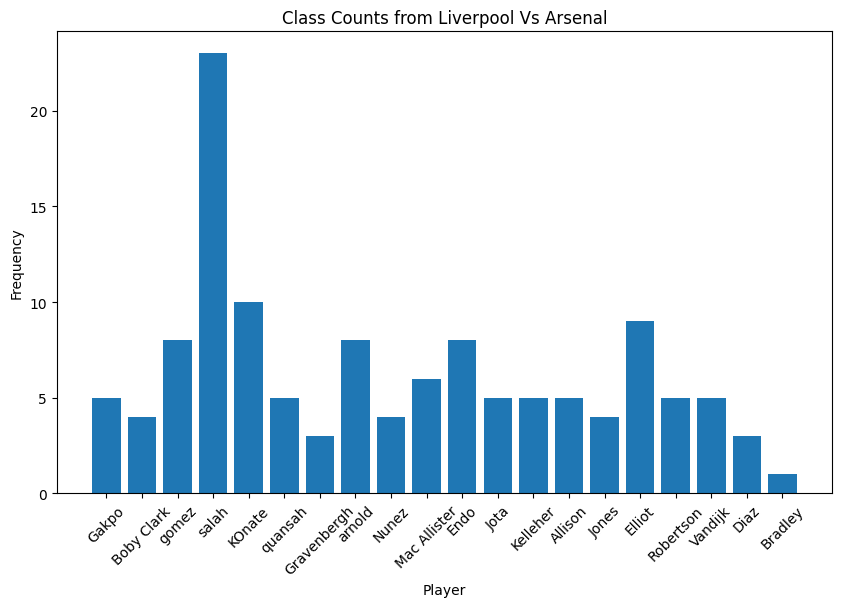

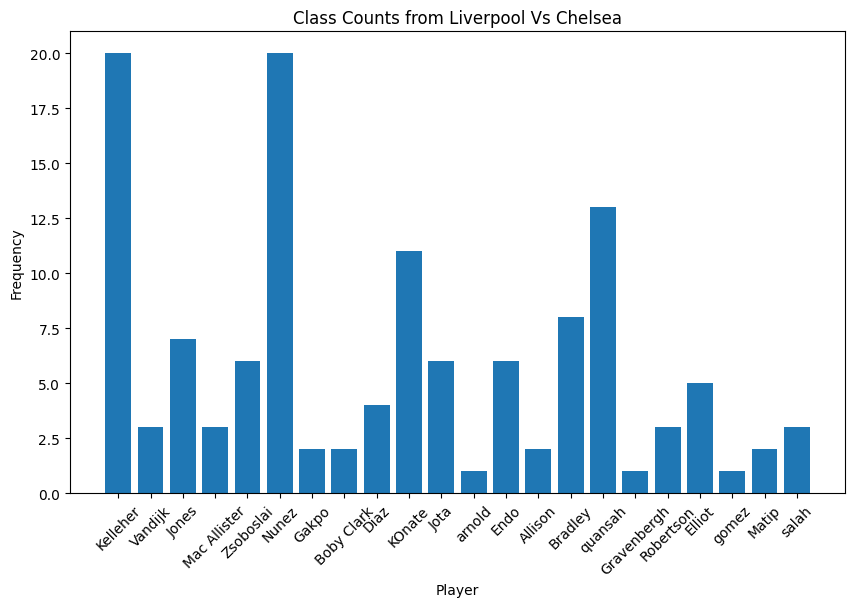

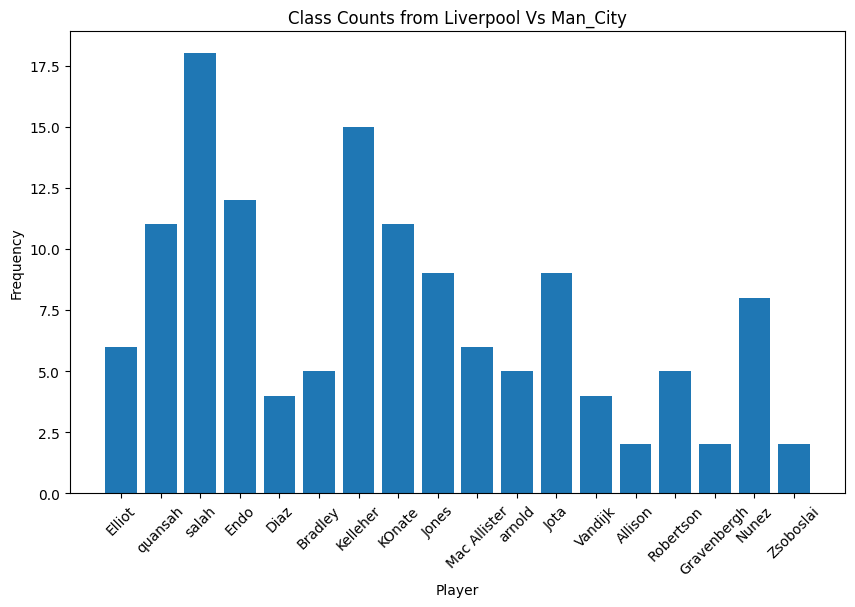

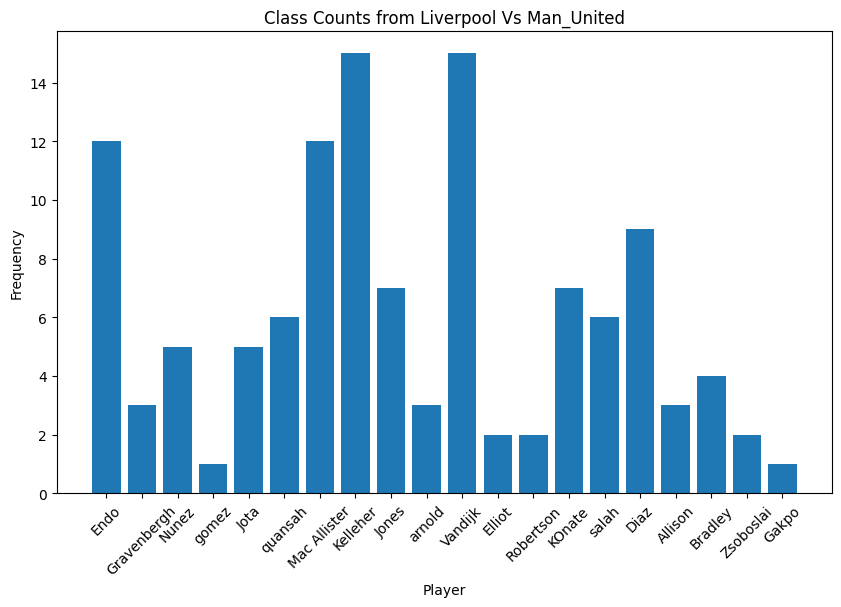

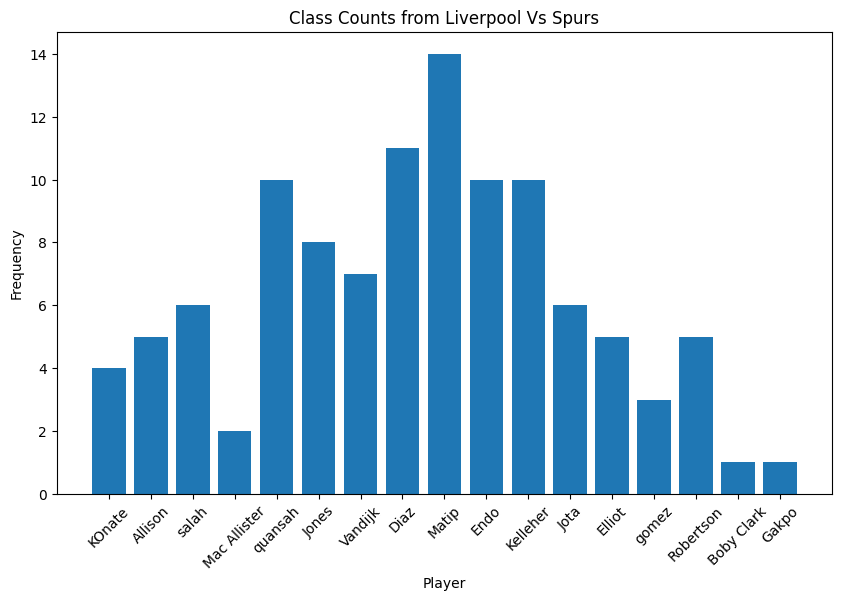

In [ ]:
import os
import csv
import matplotlib.pyplot as plt

# List of CSV files generated
csv_files = [
    '/content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Arsenal_counts.csv',
    '/content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Chelsea_counts.csv',
    '/content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Man_City_counts.csv',
    '/content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Man_United_counts.csv',
    '/content/drive/MyDrive/Highlights Project/frames/frames_smaller/df_Spurs_counts.csv'
]

# Plotting each CSV file
for csv_file in csv_files:
    # Initialize lists to store class and count
    classes = []
    counts = []

    # Open the CSV file and read its contents
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            classes.append(row['Class'])
            counts.append(int(row['Count']))

    # Get the filename without extension
    filename = os.path.basename(csv_file)
    filename_without_prefix = filename.replace("df_", "").replace("_counts.csv", "")

    # Plot the class counts
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Player')
    plt.ylabel('Frequency')
    plt.title(f'Class Counts from Liverpool Vs {filename_without_prefix}')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
pip install gdown

In [ ]:
import gdown

# Define the Google Drive file IDs and output file names
file_ids = [
    "1Vbfm-Wec4ucdd0kskDeGjNjDpAZwN0QS",
    "12tGMwcedws05UUQJWgiZO0d0TIOpkEvS",
    "1nAP5QrVGfQr7u-8qACUgsW_YL7rQchJw",
    "1k7ZdcfYXxr1PDwMciV5KCdaeOBURWfyY",
    "1s8yFVZOzNe17YKo9tjYkg-2evoeTbUSi"
]

# Download the files
downloaded_files = []
for file_id in file_ids:
    url = f"https://drive.google.com/uc?id={file_id}"
    output = f"{file_id}.jpg"
    gdown.download(url, output, quiet=False)
    downloaded_files.append(output)

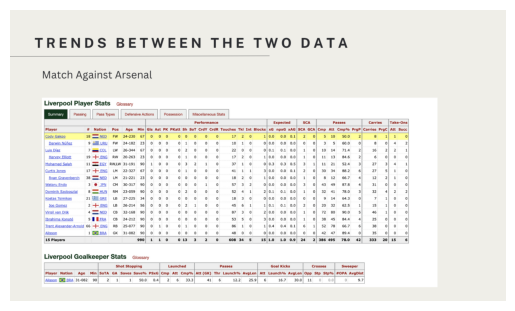

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Display the first image
img = Image.open("1Vbfm-Wec4ucdd0kskDeGjNjDpAZwN0QS.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()


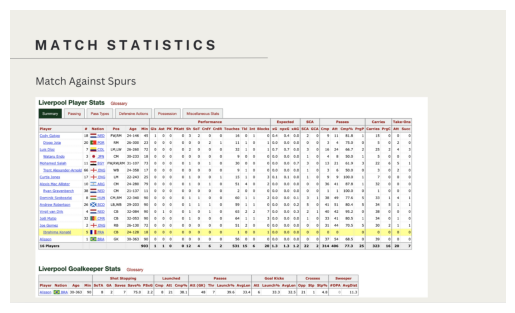

In [4]:
# Display the second image
img = Image.open("12tGMwcedws05UUQJWgiZO0d0TIOpkEvS.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()


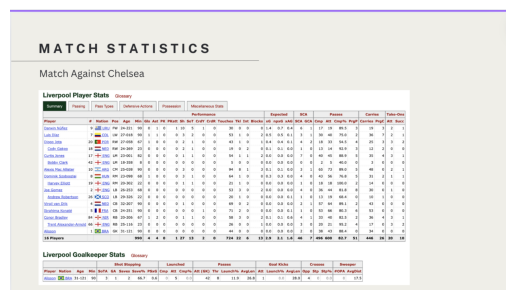

In [5]:
# Display the third image
img = Image.open("1nAP5QrVGfQr7u-8qACUgsW_YL7rQchJw.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()


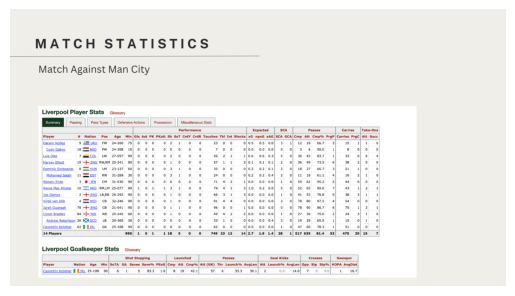

In [6]:
# Display the fourth image
img = Image.open("1k7ZdcfYXxr1PDwMciV5KCdaeOBURWfyY.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()


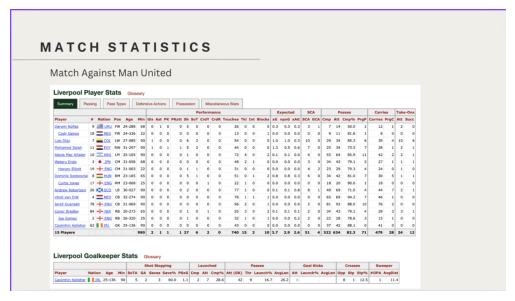

In [7]:
# Display the fifth image
img = Image.open("1s8yFVZOzNe17YKo9tjYkg-2evoeTbUSi.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()
